# *MultipathLocationEstimator* Second tutorial: estimation algorithm

*MultipathLocationEstimator* is an open-source Python class for location in multipath channels, which contains several estimation algorithms for UE **(User Equipment)** positioning. The official documentation can be found [here](https://github.com/gomezcuba/CASTRO-5G/tree/main). This document is a tutorial in Jupyter Notebook that helps users understand the internal logic and intended use of this class, divided in two parts:


1. [First tutorial](./Tutorial_1_MultipathLocationEstimator.ipynb): The first tutorial is focused in understanding the definition of the channel parameters between the BS (Base Station) and the UE. In other words, how it is established the coordinates and geometric system without going into detail in how the user position is computed.
2. [Second tutorial](./Tutorial_2_MultipathLocationEstimator.ipynb): This second tutorial is focused on understanding how UE position is estimated and computed from the channel parameters. For this purpose, <i>MultipathLocationEstimator</i> class includes different estimation algorithms that will be described along the notebook, as well as a comparison of their performance, time execution and precision in the results.

In this first tutorial you will learn how to:

1. Understand the problem of clock error
2. Create an instance of the *MultipathLocationEstimator* class
3. Computing the value of the UE position and clock error assuming $\phi_{Ao}$ is known
4. Estimate the value of $\phi_{Ao}$ (orientation offset)
5. Test and compare the different algorithms that implement the class *MultipathLocationEstimator*

# Table of Contents:

1. [Clock offset error model](#1.-Clock-offset-error-model)
2. [MultipathLocationEstimator object](#2.-MultipathEstimationLocation-object)
3. [Solving UE location with clock error](#3.-Solving-UE-location-with-clock-error)
4. [Solving UE offset orientation](#4.-Solving-UE-offset-orientation)
    - [4.1 Brute force method](#4.1-Brute-force-method)
    - [4.2 Function Root method](#4.2-Function-Root-Method)
    - [4.3 Group formation strategies](#4.3-Group-formation-strategies)
5. Solving UE location from estimated parameters
6. Performance
7. References

# 1. Clock offset error model

In the previous tutorial, we have talked about how $\phi_{Ao}$ could affect DAoA measurement. Therefore, receiver’s measured DAoA will be rotated with regard to the absolute AoA in the global coordinate system. 

In the second tutorial we will introduce the full model of the clock offset $\tau_e$. This offset will model the unknown initial time reference for the measurement of DToA at the receiver. In a LOS channel with perfect clock synchronization, the delays between the different multipath channels would be measured as
\begin{equation}
\Delta \tau_i ^{perfectLOS} = \tau_i - \tau_0
\end{equation}
whereas in a LOS with perfect clock, they would be
\begin{equation}
\Delta \tau_i ^{perfectNLOS} = \tau_i - \min\tau_i
\end{equation}
due to the fact that the receiver can only start measuring when the first signal arrives.

If we add, on top of the above, some arbitrary offset of the UE receiver clock with regard to the BS transmitter clock, we can generally represent that the receiver only knows:
\begin{equation}
\Delta \tau_i  = \tau_i - \tau_e
\end{equation}
Where $\tau_e$ absorbs in it all the mixed effects of $\tau_o$, $\min\tau_i$, the fact that the LOS condition status is unknown, and the potential circuit clock differences. For all of the above effects, regardless, the delay measurement clock offset $\tau_e$ is the same for all paths. At this stage we do not model individual independent noise components representing error in the delay measurement. 

# 2. MultipathEstimationLocation object

The *MultipathLocationEstimator* provides several algorithms recover the UE position trigonometrically, denoted $(d_{ox},d_{oy})$, as well as the value of the clock offset $\tau_e$ and UE orientation offset $\phi_o$. For this, the algorithm receives as inputs the AoDs, AoAs and DToAs as measured by the receiver.

The configuration parameters of the MultipathEstimationLocation object instance are:
    orientationMethod='lm', nPoint=100, groupMethod='drop1'
- *orientationMethod* (str, optional): Type of algorithm to recover $\phi_{Ao}$
- *nPoint* (int, optional):  Total point divisions in the range of brute force search method
- *groupMethod*: (str, optional): Type group formaiton algorithm used in the recovery of $\phi_{Ao}$

In [1]:
import sys
sys.path.append('../')

#Import for show the progress bar time execution
import time
from tqdm.notebook import tqdm

#Import for the optimization algorithms
import scipy.optimize as opt

#Import to use NumPy arrays
import numpy as np

#Import Pandas
import pandas as pd

#Import for making plots 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 18)
from mpl_toolkits import mplot3d

#Import MultipathLocationEstimator
from CASTRO5G import MultipathLocationEstimator

# Instance of MultipathLocationEstimator object
loc = MultipathLocationEstimator.MultipathLocationEstimator(nPoint = 100, orientationMethod = "lm")

# 3. Solving UE location with clock error

When the UE orientation $\phi_{Ao}$ is known, or an estimation of it is provided, it is possible to compute all locations and clock offset using a simle linear LS algorithm. This is implemented by the function

    do_est,clock_offset,d_est = MultipathLocationEstimator.computeAllPaths(paths, orientation=None)

Where *paths* is a dataframe with at least the columns "DoA" "DAoA" and "TDoA". To call this function with a perfectly known *orientation*$=\phi_{Ao}$ is quivalent to calling it with the absolute values of AoA in place of DAoA. The returned values are the estimates of UE location, clock offset, and reflector locations. Works also in 3D.

In [2]:
# Number of scattering paths (number of scatters)
Npath = 10

# We generate a random location for the Nuser users
d_0x = np.random.rand()*100 - 50
d_0y = np.random.rand()*100 - 50

# We generate random locations for scatters in a 100m [-50 y 50] square
# We place one scatter in each NLOS path
d_ix = np.random.rand(Npath)*100 - 50
d_iy = np.random.rand(Npath)*100 - 50

# All angles are in radians units
# With el mod operator, we normalize angle representation to the range 0 - 2pi
AoD_0 = np.arctan(d_0y/d_0x)
AoD_0 = np.mod(AoD_0 + np.pi*(d_0x < 0), 2*np.pi)

AoD_i = np.arctan(d_iy/d_ix)
AoD_i = np.mod(AoD_i + np.pi*(d_ix < 0), 2*np.pi)

AoA_i = np.arctan((d_iy - d_0y)/(d_ix - d_0x))
AoA_i = np.mod(AoA_i + np.pi*((d_ix - d_0x) < 0), 2*np.pi)

#We generate a random angle for UE offset
AoA_0 = np.random.rand()*2*np.pi
DAoA_i = np.mod(AoA_i - AoA_0, 2*np.pi)

# LOS path delay
c = 3e8
l_0 = abs(d_0y / np.sin(AoD_0))
ToA_0 = l_0 / c

# NLOS path delay
l_i = np.abs(d_iy / np.sin(AoD_i)) + np.abs((d_iy - d_0y) / np.sin(AoA_i))
ToA_i = l_i / c

#delay estimation error
clock_error=(40/c)*np.random.rand()
tauE=ToA_0+clock_error
TDoA_i = ToA_i - tauE

paths=pd.DataFrame({'DAoA':DAoA_i,'AoD':AoD_i,'TDoA':TDoA_i})
print(paths)

(d0_est,clkoff_est,d_est)=loc.computeAllPaths(paths,rotation=AoA_0)

#perfect location estimation without offset
paths_norotation=pd.DataFrame({'DAoA':AoA_i,'AoD':AoD_i,'TDoA':TDoA_i})
print(paths_norotation)
(d0_perf,clkoff_perf,d_perf)=loc.computeAllPaths(paths_norotation)

print("""UE location
    true value: (%.2f,%.2f) m
    estimated: (%.2f,%.2f) m
    estimated no offset: (%.2f,%.2f) m
    """%(d_0x,d_0y,d0_est[0],d0_est[1],d0_perf[0],d0_perf[1]))
print("""Clock offset
    true TauE: %.2f ns
    true Tau0: %.2f ns
    true clock offset: %.2f ns
    estimated clock offset: %.2f ns
    """%(tauE*1e9,ToA_0*1e9,clock_error*1e9,-clkoff_est*1e9))

print("Scatterer\t|true location\t\t|estimated \t\t|estimated no offset")
for npath in range(Npath):
    print("%d\t\t|(%6.2f,%6.2f) m\t|(%6.2f,%6.2f) m\t|(%6.2f,%6.2f) m"%(npath,d_ix[npath],d_iy[npath],d_est[npath,0],d_est[npath,1],d_perf[npath,0],d_perf[npath,1]))

       DAoA       AoD          TDoA
0  2.639003  6.004402  1.404064e-07
1  2.631395  5.966067  1.586946e-07
2  2.219621  5.134797  3.182423e-07
3  2.565003  5.781560  2.121168e-07
4  3.324650  0.820418  2.677707e-07
5  2.413809  5.488790  3.268568e-07
6  3.249249  0.736147  2.544020e-07
7  3.944529  2.277419  1.319857e-08
8  2.324571  5.084188  1.140453e-07
9  2.622596  0.201517  1.049596e-08
       DAoA       AoD          TDoA
0  5.810020  6.004402  1.404064e-07
1  5.802412  5.966067  1.586946e-07
2  5.390638  5.134797  3.182423e-07
3  5.736020  5.781560  2.121168e-07
4  0.212482  0.820418  2.677707e-07
5  5.584826  5.488790  3.268568e-07
6  0.137081  0.736147  2.544020e-07
7  0.832360  2.277419  1.319857e-08
8  5.495588  5.084188  1.140453e-07
9  5.793613  0.201517  1.049596e-08
UE location
    true value: (-37.42,24.72) m
    estimated: (-37.42,24.72) m
    estimated no offset: (-37.42,24.72) m
    
Clock offset
    true TauE: 177.38 ns
    true Tau0: 149.49 ns
    true clock offset

# 4. Solving UE offset orientation

In this section, we will introduce the methods for estimation of the orientation offset $\phi_{Ao}$ in the 2D case. An unknown rotation can severely limit the performance of our positioning estimation algorithm due to its randomness and non-linear impact on the method. Therefore, to deal with this constraint, we have designed some different methods that can compute its value.
- A brute forcing algorithm looks over all possible points for the range of $\phi_{Ao} \in [0, 2\pi]$
- A more sophisticated algorithm that finds the solution of a non-linear equation using the standard method *scipy.optimize.root()* from the scipy package.

Both methods are based on dividing the set of paths $\{1\dots N_p\}$ into $N_G$ groups denoted $\mathcal{G}_1,\mathcal{G}_2\dots\mathcal{G}_{N_G}$. We assume that for each group the location and clock error are estimated as a function of $\phi_{Ao}$ denoted
\begin{equation}
F_m(\phi_{Ao})=\left(\begin{array}{c}
        \hat{d}_{oy}^{(m)}\\
        \hat{d}_{ox}^{(m)}\\
        c\hat{\tau}_E^{(m)} 
     \end{array}\right)
\end{equation}

Finally, we note that for a correct value of $\phi_{Ao}$, all groups should calculate the same estimation of the location. We represent this in the next plot. In it, there are 4 paths, and we form two groups of 3 paths. When the correct $\phi_o$ is provided, both groups produce the same location result. Whereas when an incorrect $\phi_o$ is given, the two groups disagree.

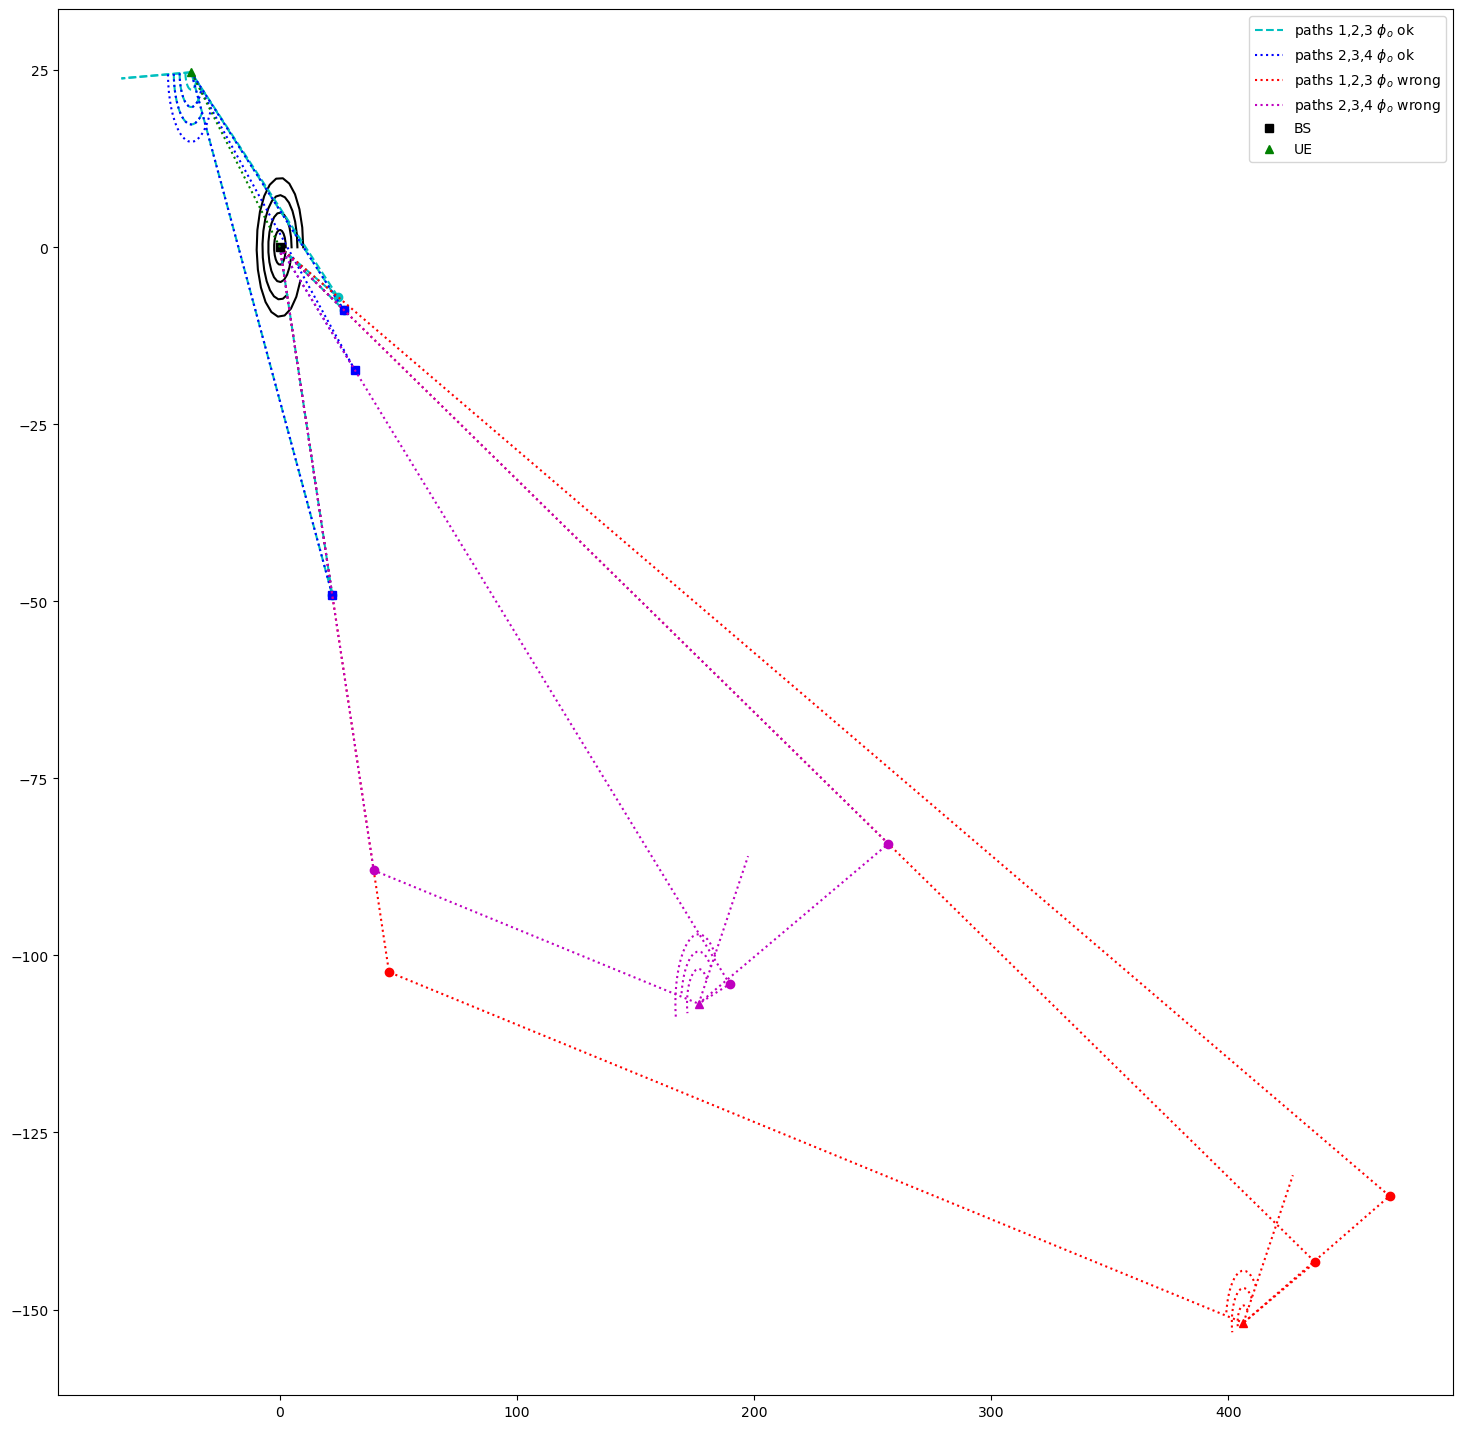

In [3]:
plt.figure(1)
scaleguide=np.max(np.abs(np.concatenate([[d_0x],[d_0y],d_ix,d_iy],0)))
t=np.linspace(0,1,21)

#show 4 path AODs
for p in range(4):
    plt.plot(0+scaleguide*.05*(p+1)*np.cos(AoD_i[p]*t),0+scaleguide*.05*(p+1)*np.sin(AoD_i[p]*t),'k', label='_nolegend_')

#paths in G1 = {1...3}, with AoAs and correct AoA_0 leading to correct location
plt.plot([d_0x,d_0x+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.cos(AoA_0)],[d_0y,d_0y+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.sin(AoA_0)],'c--', label='_nolegend_')
for of in range(3):
    p=0+of
    plt.plot([0,d_ix[p],d_0x],[0,d_iy[p],d_0y],'c--', label='_nolegend_' if of > 0 else '')
    plt.plot(d_ix[p],d_iy[p],'oc', label='_nolegend_')    
    plt.plot(d_0x+scaleguide*.05*(p+1)*np.cos(DAoA_i[p]*t+AoA_0),d_0y+scaleguide*.05*(p+1)*np.sin(DAoA_i[p]*t+AoA_0),'c--', label='_nolegend_')

#paths in G2 = {2...4}, with AoAs and correct AoA_0 leading to correct location
plt.plot([d_0x,d_0x+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.cos(AoA_0)],[d_0y,d_0y+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.sin(AoA_0)],'c--', label='_nolegend_')
for of in range(3):
    p=1+of
    plt.plot([0,d_ix[p],d_0x],[0,d_iy[p],d_0y],'b:', label='_nolegend_' if of > 0 else '')
    plt.plot(d_ix[p],d_iy[p],'sb', label='_nolegend_')    
    plt.plot(d_0x+scaleguide*.05*(p+1)*np.cos(DAoA_i[p]*t+AoA_0),d_0y+scaleguide*.05*(p+1)*np.sin(DAoA_i[p]*t+AoA_0),'b:', label='_nolegend_')

#wrong location estimated by paths in G1 = {1...3}, with AoAs and incorrect AoA_0 leading to wrong location

paths=pd.DataFrame({'DAoA':DAoA_i,'AoD':AoD_i,'TDoA':TDoA_i})
(d0_bad,tauEall_bad,d_bad)= loc.computeAllPaths(paths[0:3],np.pi/4)
plt.plot(d0_bad[0],d0_bad[1],'^r', label='_nolegend_')
plt.plot([d0_bad[0],d0_bad[0]+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.cos(np.pi/4)],[d0_bad[1],d0_bad[1]+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.sin(np.pi/4)],'r:', label='_nolegend_')
for of in range(3):
    p=0+of
    plt.plot([0,d_bad[of,0],d0_bad[0]],[0,d_bad[of,1],d0_bad[1]],'r:', label='_nolegend_' if of > 0 else '')
    plt.plot(d_bad[of,0],d_bad[of,1],'or', label='_nolegend_')
    plt.plot(d0_bad[0]+scaleguide*.05*(p+1)*np.cos(DAoA_i[p]*t+np.pi/4),d0_bad[1]+scaleguide*.05*(p+1)*np.sin(DAoA_i[p]*t+np.pi/4),'r:', label='_nolegend_')

#wrong location estimated by paths in G2 = {2...4}, with AoAs and incorrect AoA_0 leading to wrong location
(d0_bad,tauEall_bad,d_bad)= loc.computeAllPaths(paths[1:4],np.pi/4)
plt.plot(d0_bad[0],d0_bad[1],'^m', label='_nolegend_')
plt.plot([d0_bad[0],d0_bad[0]+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.cos(np.pi/4)],[d0_bad[1],d0_bad[1]+1.2*scaleguide*.05*np.shape(AoD_i)[0]*np.sin(np.pi/4)],'m:', label='_nolegend_')
for of in range(3):
    p=1+of
    plt.plot([0,d_bad[of,0],d0_bad[0]],[0,d_bad[of,1],d0_bad[1]],'m:', label='_nolegend_' if of > 0 else '')
    plt.plot(d_bad[of,0],d_bad[of,1],'om', label='_nolegend_')
    plt.plot(d0_bad[0]+scaleguide*.05*(p+1)*np.cos(DAoA_i[p]*t+np.pi/4),d0_bad[1]+scaleguide*.05*(p+1)*np.sin(DAoA_i[p]*t+np.pi/4),'m:', label='_nolegend_')

plt.plot(0,0,'sk')
plt.plot(d_0x,d_0y,'^g')
plt.plot([0,d_0x],[0,d_0y],':g')
plt.legend(['paths 1,2,3 $\\phi_o$ ok','paths 2,3,4 $\\phi_o$ ok','paths 1,2,3 $\\phi_o$ wrong','paths 2,3,4 $\\phi_o$ wrong','BS','UE'])


Therefore, to find the correct value of $\phi_{Ao}$ we can simply solve the system of non-linear equations of $\phi_{Ao}$ given by $F_{1}(\phi_{Ao})=F_{2}(\phi_{Ao})=\dots=F_{N_G}(\phi_{Ao})$. To accomodate the use case where multipath data is not known perfectly and location commits errors, we solve this system of equations in the *Minimum Mean Squared Error* (MMSE) sense, that is we minimize
\begin{equation}
 %\label{eq:minmselin}
 \hat{\phi}_{Ao}= \min_{x}\sum_{m=1}^{N_G} \left\|F_{m}(x)-\overline{F}(x)\right\|^2\textnormal{ s.t. }\overline{F}(x)=\frac{\sum_{m=1}^{N_G} F_{m}(x)}{N_G}
\end{equation}

This cost function is implemented by the method

    MultipathLocationEstimator.locMSEByPathGroups(x, paths, groupMethod='drop1'):
    
Which receives the sets of multipath values as inputs, as well as a *group_method* optional parameter.
* x (ndarray):  Values of AoA0 to be evaluated.
* paths (dataframe) values of AoD, DAoA of all paths
* group_method (optional): Path grouping method. In the later sections we explain more about the different grouping strategies. The default value is the 'drop1' proposed method.
This method returns the MSE among the potential estimated locations from each group for a given value of $\phi_{Ao}$ using the linear algorithm given in the previous section.

## 4.1 Brute force method
A trivial approach to find (an approximation of) the correct $\phi_{Ao}$ in the MMSE expression above is brute-force search. The brute force method generates thousands of points in the interval of $[0, 2\pi]$ and picks the one with the lowest MSE. This is achieved by the method

     loc.bruteAoA0ForAllPaths(paths, Npoint , group_method )

which calls *feval_wrapper_AllPathsByGroupsFun* with Npoint equispaced trest values of $\phi_o$ and returns that with the lowest MSE. In addition to the same input values as *feval_wrapper_AllPathsByGroupsFun*, the input value
* Npoint (int): Is the number of points in the interval $[0, 2\pi]$ to be evaluated.

The performance of this estimator will be determined by the grouping methodology, *group_method*, and the number of divisions of the interval. This method can be extremely time-consuming depending onthe these two last call variables, as the complexity is roughly equal to $N_{point} \times N_{group}$ matrix inversions of size $N_{paths\_per\_group}\times 3$. In addition the resolution is limited to $2\pi/N_{point}$ even in the case with perfect multipath information. Therefore, it is important to look for an agreement between these parameters and try to search the best for each scenario.

In [4]:
%time brute_AoA0_verycoarse = loc.bruteAoA0ByPathGroups(paths, nPoint = 10, groupMethod="drop1")
%time brute_AoA0_coarse = loc.bruteAoA0ByPathGroups(paths, nPoint = 100, groupMethod="drop1")
%time brute_AoA0 = loc.bruteAoA0ByPathGroups(paths, nPoint = 1000, groupMethod="drop1")



print("""
brute AoA0 25 points = %.1f º
brute AoA0 100 points = %.1f º
brute AoA0 1000 points = %.1f º
true AoA0 = %.1f º
"""%(brute_AoA0_verycoarse*180/np.pi,brute_AoA0_coarse*180/np.pi,brute_AoA0*180/np.pi,AoA_0*180/np.pi))

CPU times: user 88.5 ms, sys: 2.13 ms, total: 90.6 ms
Wall time: 88.8 ms
CPU times: user 742 ms, sys: 0 ns, total: 742 ms
Wall time: 741 ms
CPU times: user 7.08 s, sys: 1.1 ms, total: 7.08 s
Wall time: 7.08 s

brute AoA0 25 points = 200.0 º
brute AoA0 100 points = 181.8 º
brute AoA0 1000 points = 181.6 º
true AoA0 = 181.7 º



## 4.2 Function Root Method

To address the resolution and computational shortcomings of the brute force method, we introduce the use the tool *scipy.optimize.root()* to find the zero of the target function in the previous section. In the case that the multipath information is perfectly known, it should be possible for all groups to agree perfectly and the correct value of $\phi_{Ao}$. Nevertheless, we would like to build an estimator that also works well when the multipath information is slightly in error (for example in the case of dictionary-based Compressed Sensing channel estimation). Fortunately, *scipy.optimize.root()* is a multi-algorithm tool that includes the possibility of solving equations in a MMSE sense, using the 'LM' algorithm. By choosing this solver as optional argument, we solve $\phi_{Ao}$ in a MMSE sense, with the exact solution as a special noiseless case.

The minimization algorithm can also can receive an initialization point, like a guess or hint about what is the value of $\phi_{Ao}$. This initialization value can be very useful so we can make a large aproximation with the brute force algorithm to better initialize the search. Nowadays, in commercial mobile phones there are available some sensors as acelerometers, giroscopes and magnetometers that are capable of measuring orientation angles in the different axes $(x, y, z)$. Therefore this feature can also benefit from the hardware capabilities for initialization.

In summary, the method

    MultipathLocationEstimator. solveAoA0ForAllPaths(self, paths, init_AoA0, groupMethod='drop1', orientationMethod='lm'):

Obtains estimates the value of $\phi_{Ao}$ in a MMSE sense by relying on the codes of *scipy.optimize.root()* and *bruteAoA0ForAllPaths* as const function. Besides the usual, the novel input parameners are:
* init_AoA0 (float): provides the initial point for the search function.
* orientationMethod (str,optional): permits to request a different root algorithm. The default value is 'LM'. WARNING the other algorithms of the root library do not have a defined behavior to solve approximate equations, so this option will produce unexpected or undefined results if used in conjunction with approximate multipath estimation.


In [5]:
%time AoA0_startsearch =  loc.bruteAoA0ByPathGroups(paths, nPoint = 25, groupMethod="drop1")
%time AoA0_fsolve, _ = loc.numericRot0ByPathGroups(paths, AoA0_startsearch, groupMethod="drop1", orientationMethod = "lm")

print("""
brute AoA0 1000 points = %.1f º
brute AoA0 initialization = %.1f º
AoA0 root = %.1f º
true AoA0 = %.1f º
""" % (brute_AoA0*180/np.pi,AoA0_startsearch*180/np.pi,AoA0_fsolve[0]*180/np.pi,AoA_0*180/np.pi) )

CPU times: user 204 ms, sys: 3.4 ms, total: 207 ms
Wall time: 202 ms
CPU times: user 77 ms, sys: 913 µs, total: 77.9 ms
Wall time: 77.5 ms

brute AoA0 1000 points = 181.6 º
brute AoA0 initialization = 180.0 º
AoA0 root = 181.7 º
true AoA0 = 181.7 º



As we can see in the example above the advantages of the root method are:

1. **Enhanced precision**
2. **Faster computation time** (for high precision results including coarse brute force initialization)
3. **Support for sensor data as initialization**

## 4.3 Group formation strategies

So far we have described the methods to estimate $\phi_{Ao}$ given a collection of user groups. We shall now discuss the group strategies and how they can affect the estimation performance. We recall that we wish to form $N_G$ groups or subsets of paths, that for each group a matrix inversion of size $N_{paths\_per\_group}$ is performed, and that using non-linear algorithms the  $\phi_{Ao}$ value is computed. Due to this, it's important to introduce the constraint that minimal number of paths per group is at least 3 (so that the linear location algorithm can be run on each group). Moreover, due to the fact that the system of equations to find $\phi_{Ao}$  is non-linear, the number of groups should also be greater than $N_G>2$ in order to discard false positive solutions. 

The optional argument *groupMethod* may take two different formats. In the general case, it consists of a boolean array of size $N_G \times N_{paths}$ where a True value at index [m,p] represents that the path $p$ is in the group $m$. Let us give an example: suppose that there are $5$ paths and we with to define two groups $\mathcal{G}_1=\{1,2,4\}$ and  $\mathcal{G}_2=\{1,3,5\}$, we can define these groups with the code

    group_method = [
                    [True , True , False, True , False ],
                    [True , False, True , False, True  ],
                   ]

To avoid the hassle of creating such binary tables, the *MultipathLocationEstimator* module provides 3 predefined group strategies. To use one of these, instead of a boolean array it is possible to simply provide the str names of these methods:

   
*groupMethod = '3path'*: This strategy uses groups of the minimal size in order to reduce the computation time caused by matrix inversions. A sliding-window group formation schem is employed, producing $\mathcal{G}_1=\{1,2,3\},\mathcal{G}_2=\{2,3,4\},\dots,\mathcal{G}_{N_{path}-2}=\{N_{path}-2,N_{path}-1,N_{path}\}$.

In [6]:
table_group_3path = loc.genKPathGroup(Npath,3)

print(table_group_3path)

[[ True  True  True False False False False False False False]
 [False  True  True  True False False False False False False]
 [False False  True  True  True False False False False False]
 [False False False  True  True  True False False False False]
 [False False False False  True  True  True False False False]
 [False False False False False  True  True  True False False]
 [False False False False False False  True  True  True False]
 [False False False False False False False  True  True  True]]


*groupMethod = 'drop1'*: This strategy uses groups of the maximal size in order to reduce the divergence of location estimations at the expense of computation complexity. There are $N_{path}$ groups and each of them is defined as "the group of all paths except the m-th" $\mathcal{G}_m=\{1,2,\dots,m-1,m+1,\dots N_{path}\}$.

In [7]:
table_group_drop1 = loc.genDrop1Group(Npath)

print(table_group_drop1)

[[False  True  True  True  True  True  True  True  True  True]
 [ True False  True  True  True  True  True  True  True  True]
 [ True  True False  True  True  True  True  True  True  True]
 [ True  True  True False  True  True  True  True  True  True]
 [ True  True  True  True False  True  True  True  True  True]
 [ True  True  True  True  True False  True  True  True  True]
 [ True  True  True  True  True  True False  True  True  True]
 [ True  True  True  True  True  True  True False  True  True]
 [ True  True  True  True  True  True  True  True False  True]
 [ True  True  True  True  True  True  True  True  True False]]


*groupMethod = 'random'*: This strategy creates *Ngroup* groups of *Nmember* elements each uniformly distributed from a random choice distribution. This permits to average the perfonance of the estimator among all possible group formation approaches of a given size.

In [8]:
Ngroups = 6
Nmembers = 4
table_group_random = loc.genRandomGroup(Npath, Ngroups, Nmembers)

print(table_group_random)

[[False False  True False  True False False  True  True False]
 [ True False False  True False  True False  True False False]
 [False False  True  True False  True  True False False False]
 [ True  True False  True False False  True False False False]
 [ True False False False  True  True False False False  True]
 [False False False  True  True False  True False  True False]]


Next we sill demonstrate the influence of the different group formation schemes in the system of non-linear equations. For that we depict a series of curves corresponding to the estimated location according to each group, for all candidate values of $\phi_{Ao}$. The point in the graph where all curves meet is the correct solution. Other candidate points when two curves cross are incorrect candidate solutions, avoided by considering 3 or more groups at the same time.

The next figure shows the system of equations for the '3-path' grouping scheme. As we can see in the plot, all the curves corresponding to different estimations of the location according to different grous cross at a single, where the UE is truly located. Hence, at that point the value of the offset orientation is obtained. Nevertheless, this grouping methodology presents several disadvantages. As the curves diverge sharply, we have noted that the performance of the location algorithm is degraded. Nevertheless, this scheme permits faster computation.

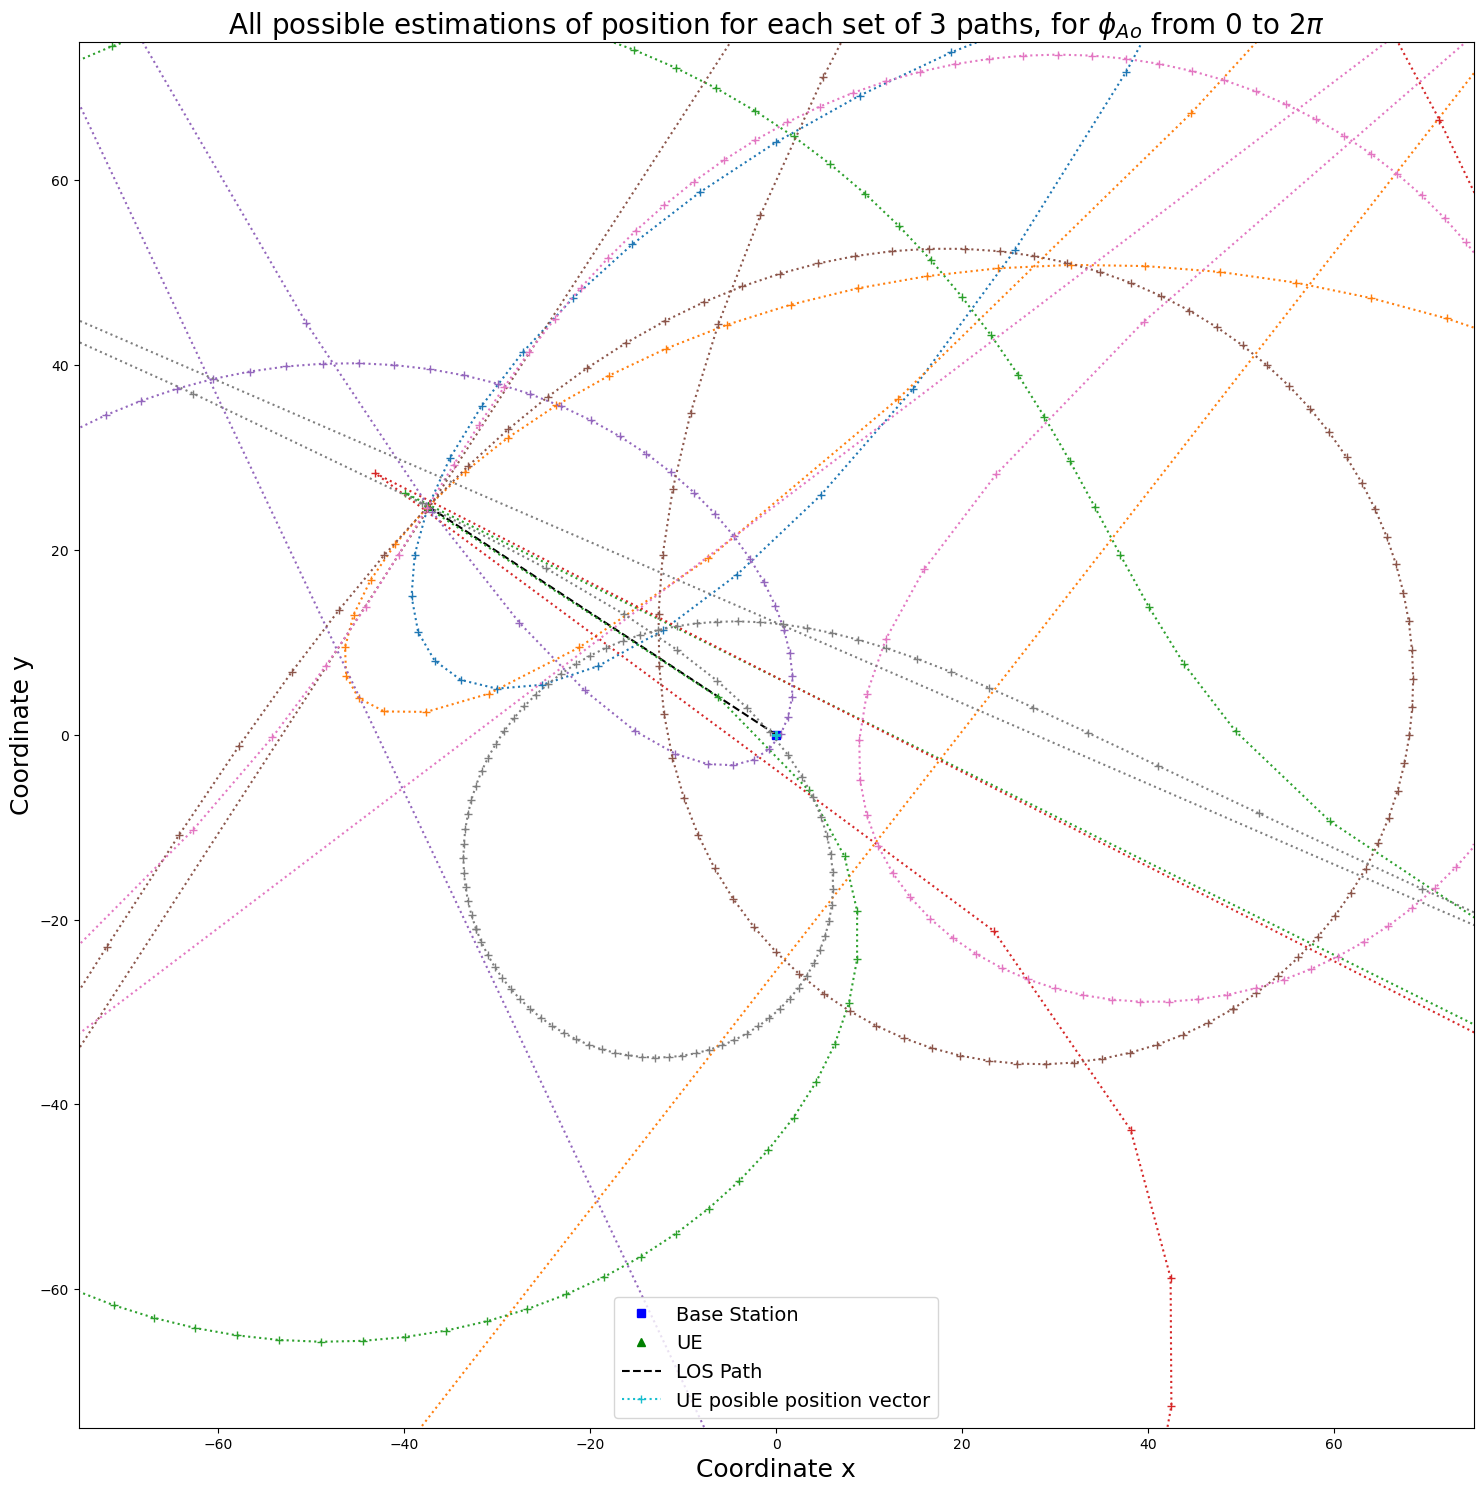

In [9]:
# Number of points to search the AoA_0 angle
Npoint = 100
AoA_0_search = np.linspace(0, 2*np.pi, Npoint).reshape(-1, 1)

# Compute all posible UE positions for AoA_0_search range
d0_3path = np.zeros((Npoint,Npath,2))

for ct in range(AoA_0_search.size):
    for gr in range(table_group_3path.shape[0]):
        (d0_3path[ct,gr,:],_, _) = loc.computeAllPaths(paths[table_group_3path[gr, :]], rotation=AoA_0_search[ct])

plt.figure(2)

# Plot the Base Station
plt.plot(0, 0, "sb", label="Base Station")

# Plot the user
plt.plot(d_0x, d_0y, "^g", label="UE")

# Plot LOS path
plt.plot([0, d_0x], [0, d_0y], "--k", label="LOS Path")

# Plot all vectors [x0, y0] solutions
plt.plot(d0_3path[:,:,0], d0_3path[:,:,1], ":+", label="UE posible position vector")

# Limits because curves diverge sharply
plt.axis([-75,75,-75,75])

plt.title("All possible estimations of position for each set of 3 paths, for $\\phi_{Ao}$ from 0 to 2$\\pi$", fontsize=20)
plt.xlabel("Coordinate x", fontsize=18)
plt.ylabel("Coordinate y", fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

The next figure shows the system of equations for the 'drop' grouping scheme. As we can see in the plot, all the curves diverge mucho more smoothly and there are no abrupt changes. We have observed in simulations that this grouping scheme leads to more precise estimation of $\phi_o$ and the UE locations, albeit at the expense of increased computational complexity. 

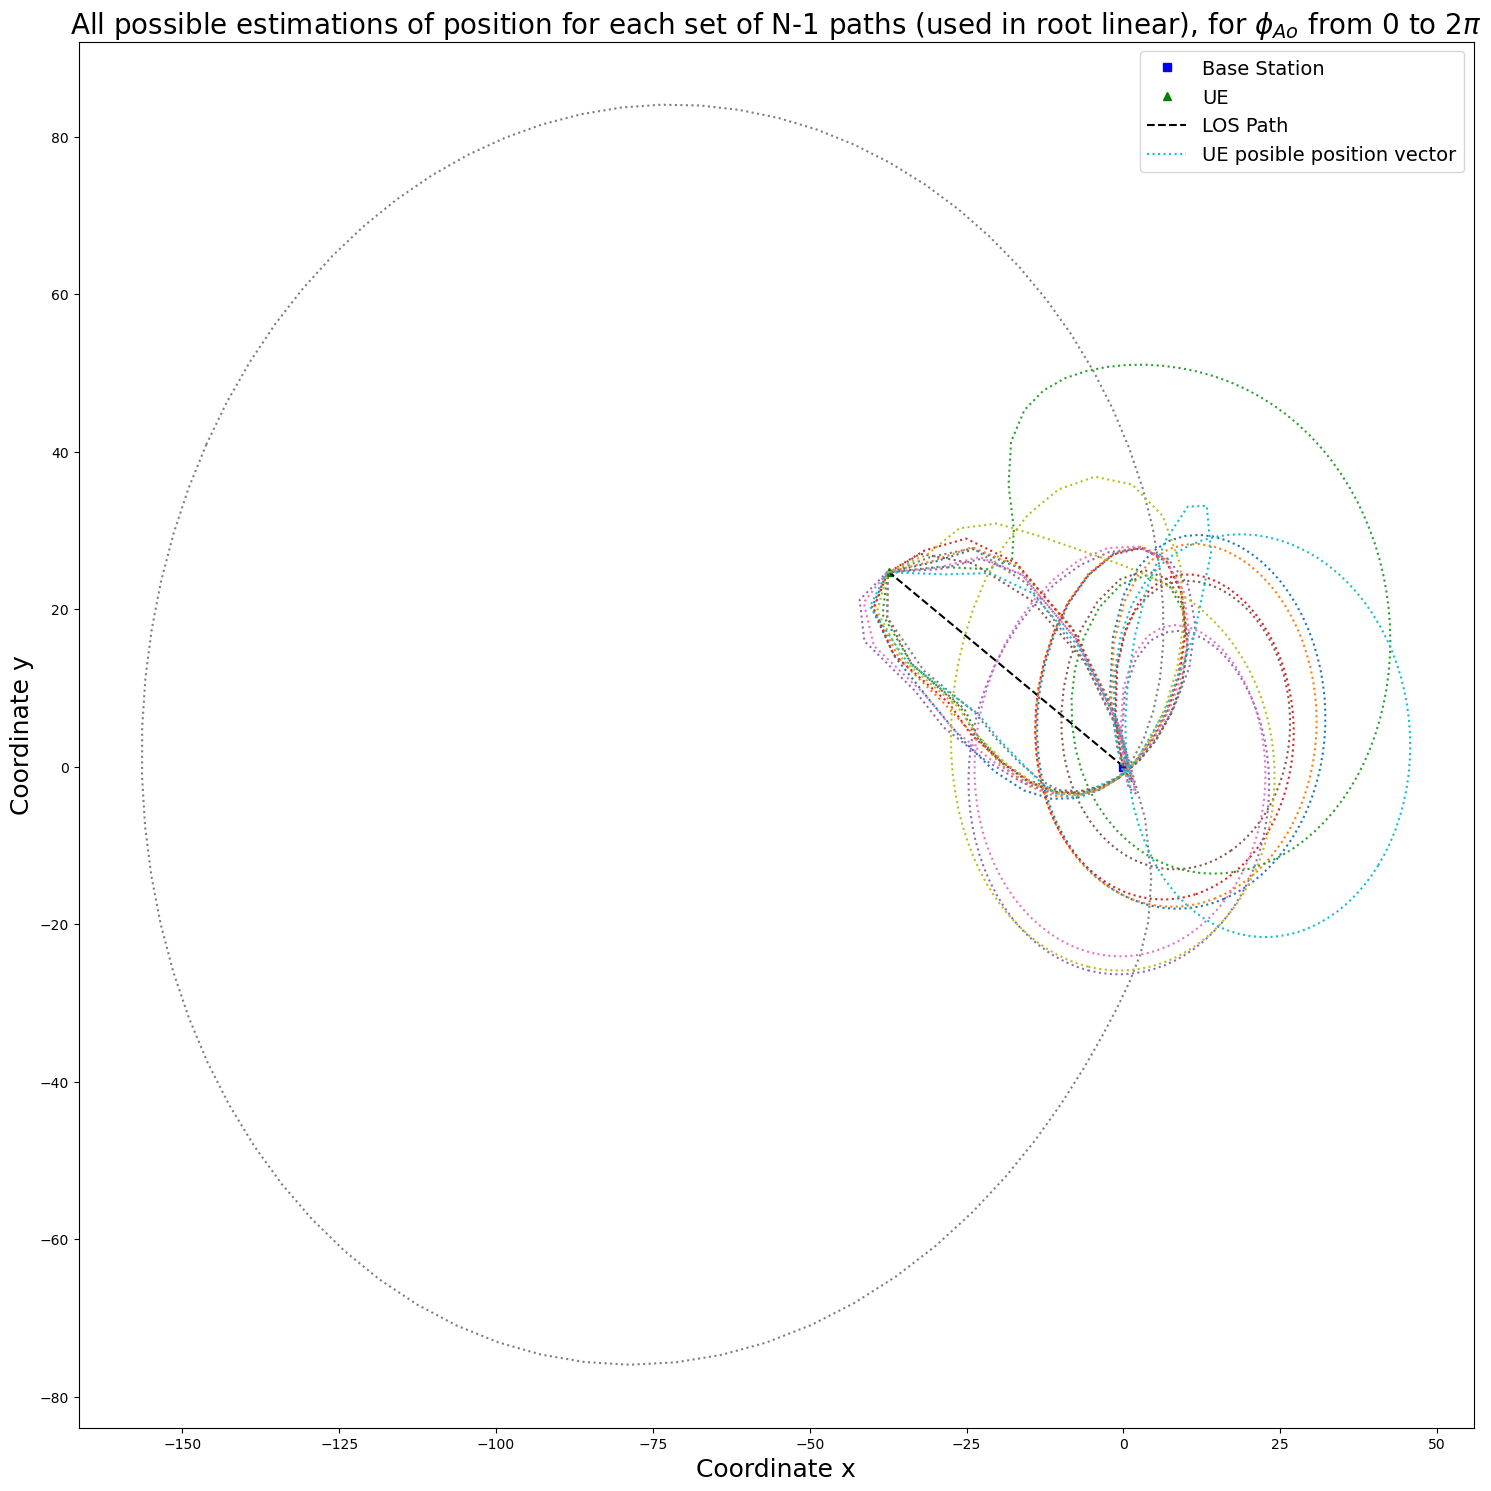

In [10]:
# Compute all posible UE positions for AoA_0_search range
d0_drop1 = np.zeros((Npoint,Npath,2))
tauE_drop1 = np.zeros((Npoint,Npath))

for ct in range(AoA_0_search.size):
    for gr in range(table_group_drop1.shape[0]):
        (d0_drop1[ct,gr,:], tauE_drop1[ct,gr], _) = loc.computeAllPaths(paths[table_group_drop1[gr, :]], rotation=AoA_0_search[ct])

plt.figure(3)

# Plot the Base Station
plt.plot(0, 0, "sb", label="Base Station")

# Plot the user
plt.plot(d_0x, d_0y, "^g", label="UE")

# Plot LOS path
plt.plot([0, d_0x], [0, d_0y], "--k", label="LOS Path")

# Plot all vectors [x0, y0] solutions
plt.plot(d0_drop1[:,:,0], d0_drop1[:,:,1], ":", label="UE posible position vector")

plt.title("All possible estimations of position for each set of N-1 paths (used in root linear), for $\\phi_{Ao}$ from 0 to 2$\\pi$", fontsize=20)
plt.xlabel("Coordinate x", fontsize=18)
plt.ylabel("Coordinate y", fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

In the examples above, the curves are represented in 2D with dimensions $(d_{ox},d_{oy})$ in order to better illustrate the problem. Nevertheless, in the actual estimator we use a 3D location function in the MMSE minimization where we also take into account the error of the estimation of the clock offset $(d_{ox},d_{oy},c\tau_E)$.

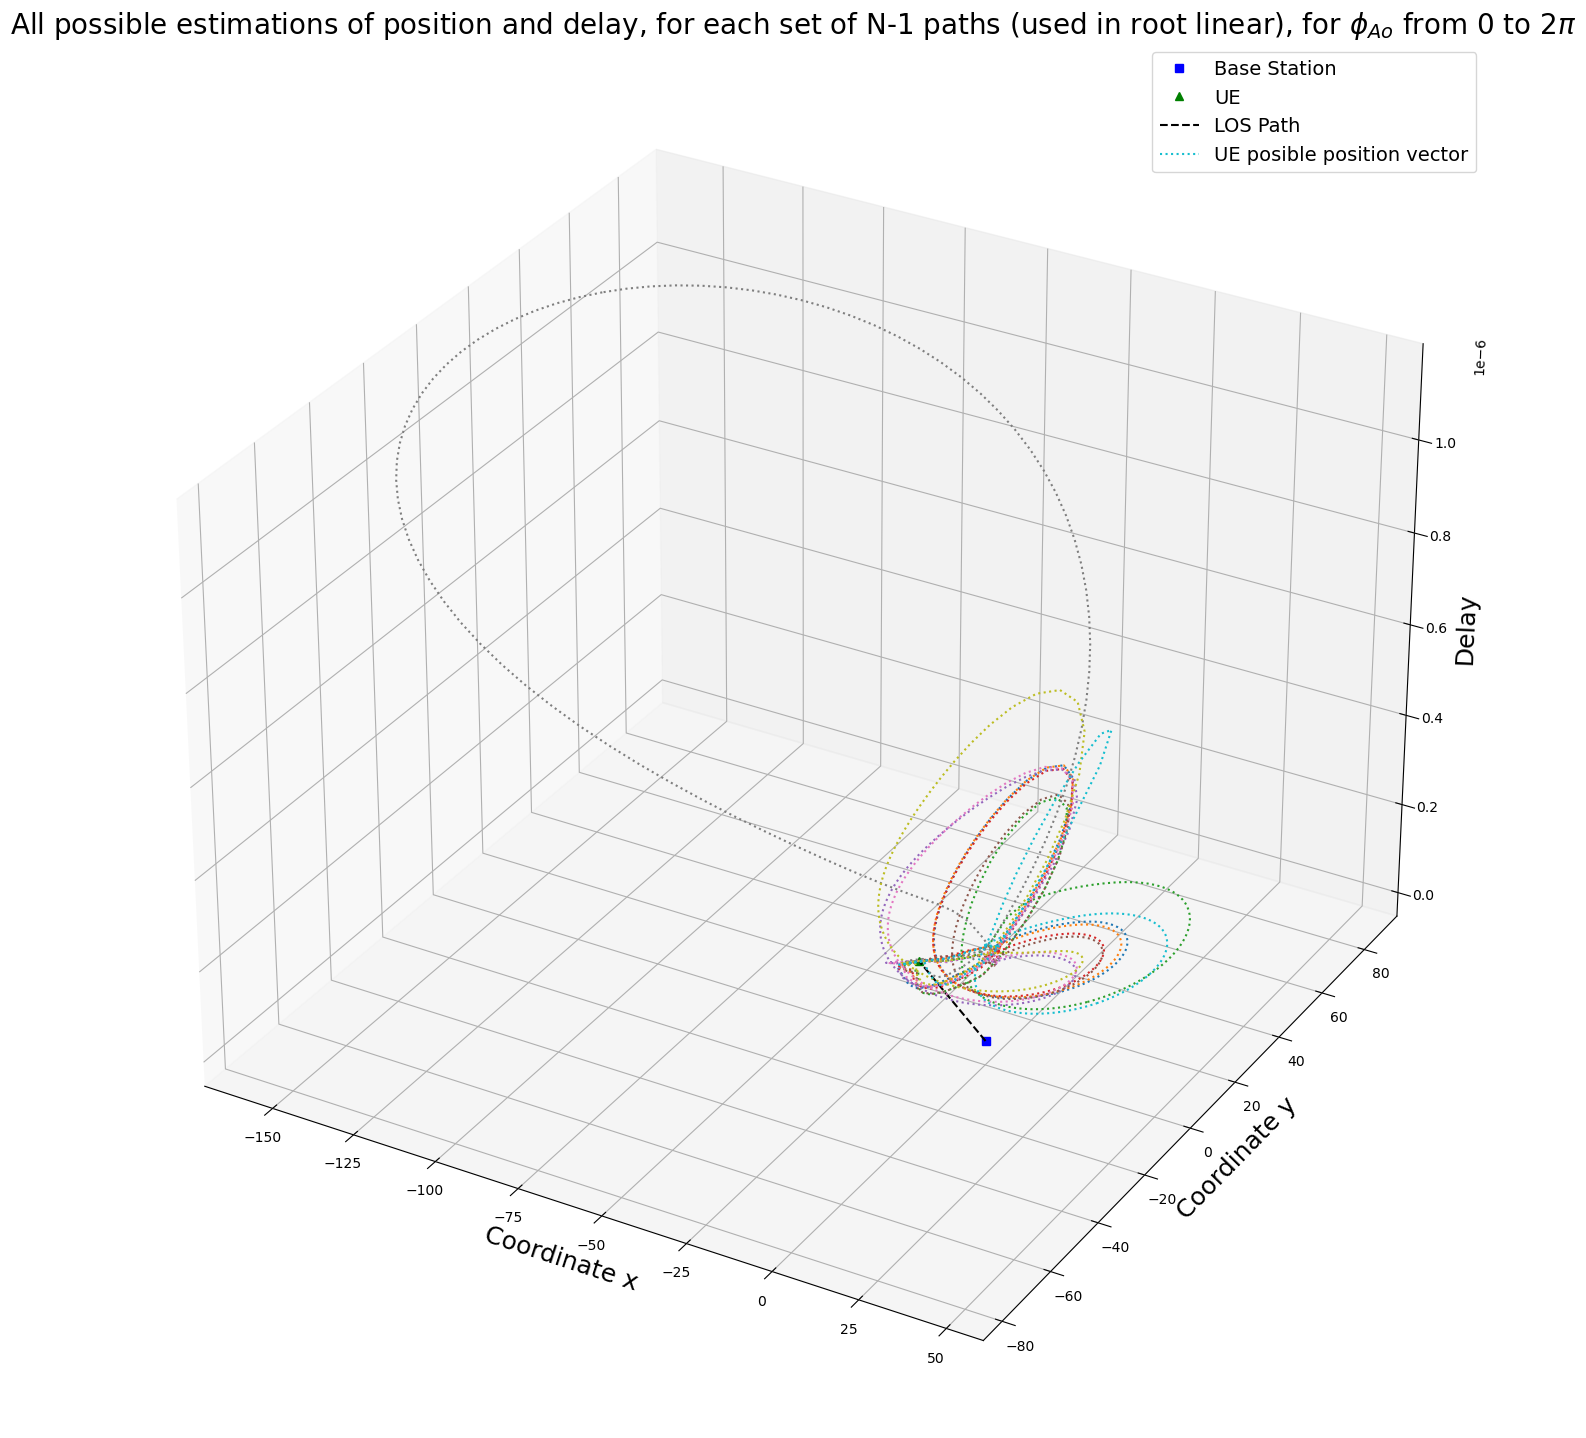

In [11]:
plt.figure(4)
ax = plt.axes(projection = "3d")

# Plot the Base Station
ax.plot3D(0,0,0, "sb", label="Base Station")

# Plot the UE
ax.plot3D(d_0x, d_0y, -clock_error, "^g", label="UE")

# Plot LOS path
ax.plot3D([0, d_0x], [0, d_0y],  [0, -clock_error], "--k", label="LOS Path")

# Plot all vectors [x0, y0] solutions
for gr in range(Npath):
    ax.plot3D(d0_drop1[:,gr,0], d0_drop1[:,gr,1], tauE_drop1[:,gr], ':', label="UE posible position vector")
    
plt.title("All possible estimations of position and delay, for each set of N-1 paths (used in root linear), for $\\phi_{Ao}$ from 0 to 2$\\pi$", fontsize=20)
ax.set_xlabel("Coordinate x", fontsize=18)
ax.set_ylabel("Coordinate y", fontsize=18)
ax.set_zlabel("Delay", fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

# 5. Solving UE location

Combining all the methods discussed in the previous section, the overal interface for the use of the estimation library is the method

    MultipathLocationEstimator.computeAllLocationsFromPaths(paths, orientationMethod=None, orientationMethodArgs={'groupMethod':'drop1','hintRotation':None}):

This method combines all parameters and constraints of our system model to perform the final robust UE location.

This function returns 
* The estimated position of the UE
* The estimated clock error
* The estimated position of all scatterers
* The estimated orientation offset
* The covariance of the orientation estimator
  
The input parameters are
* The multipath data AoD, DAoA and TDoA, which may be exact or approximated
* *orientationMethod*: either "brute force" or the desired *scipy.optimize.root()* algorithm
* *orientationMethodArgs*: a dictionary containing arguments for the orientation method 

To demonstrate the library we generate $N_{user} = 100$ UE positions $(d_{0x}, d_{0y})$ and $N_{path} × N_{user} = 20×100$ reflector locations $(d_{ix}, d_{iy})$, both randomly uniformly distributed in a square of size of $(100 * 100) m$, that simulates the plane where UE, BS and scatter are placed. The terminal orientation is also random $\phi_{Ao}\sim U(0, 2\pi)$.

            AoD      DAoA          TDoA
0  0   5.256734  2.648379  3.736491e-07
   1   1.953084  5.545951  2.320262e-07
   2   3.598824  1.293230  2.510225e-07
   3   0.610486  3.858844  1.700460e-07
   4   3.098908  1.299934  6.695801e-08
...         ...       ...           ...
14 15  3.807732  0.973150  4.199473e-07
   16  1.840941  6.180639  1.553621e-07
   17  0.870246  4.414017  7.035260e-08
   18  1.314577  0.872168  6.786573e-09
   19  0.373396  1.170102  3.027878e-09

[300 rows x 3 columns]


  0%|          | 0/15 [00:00<?, ?it/s]

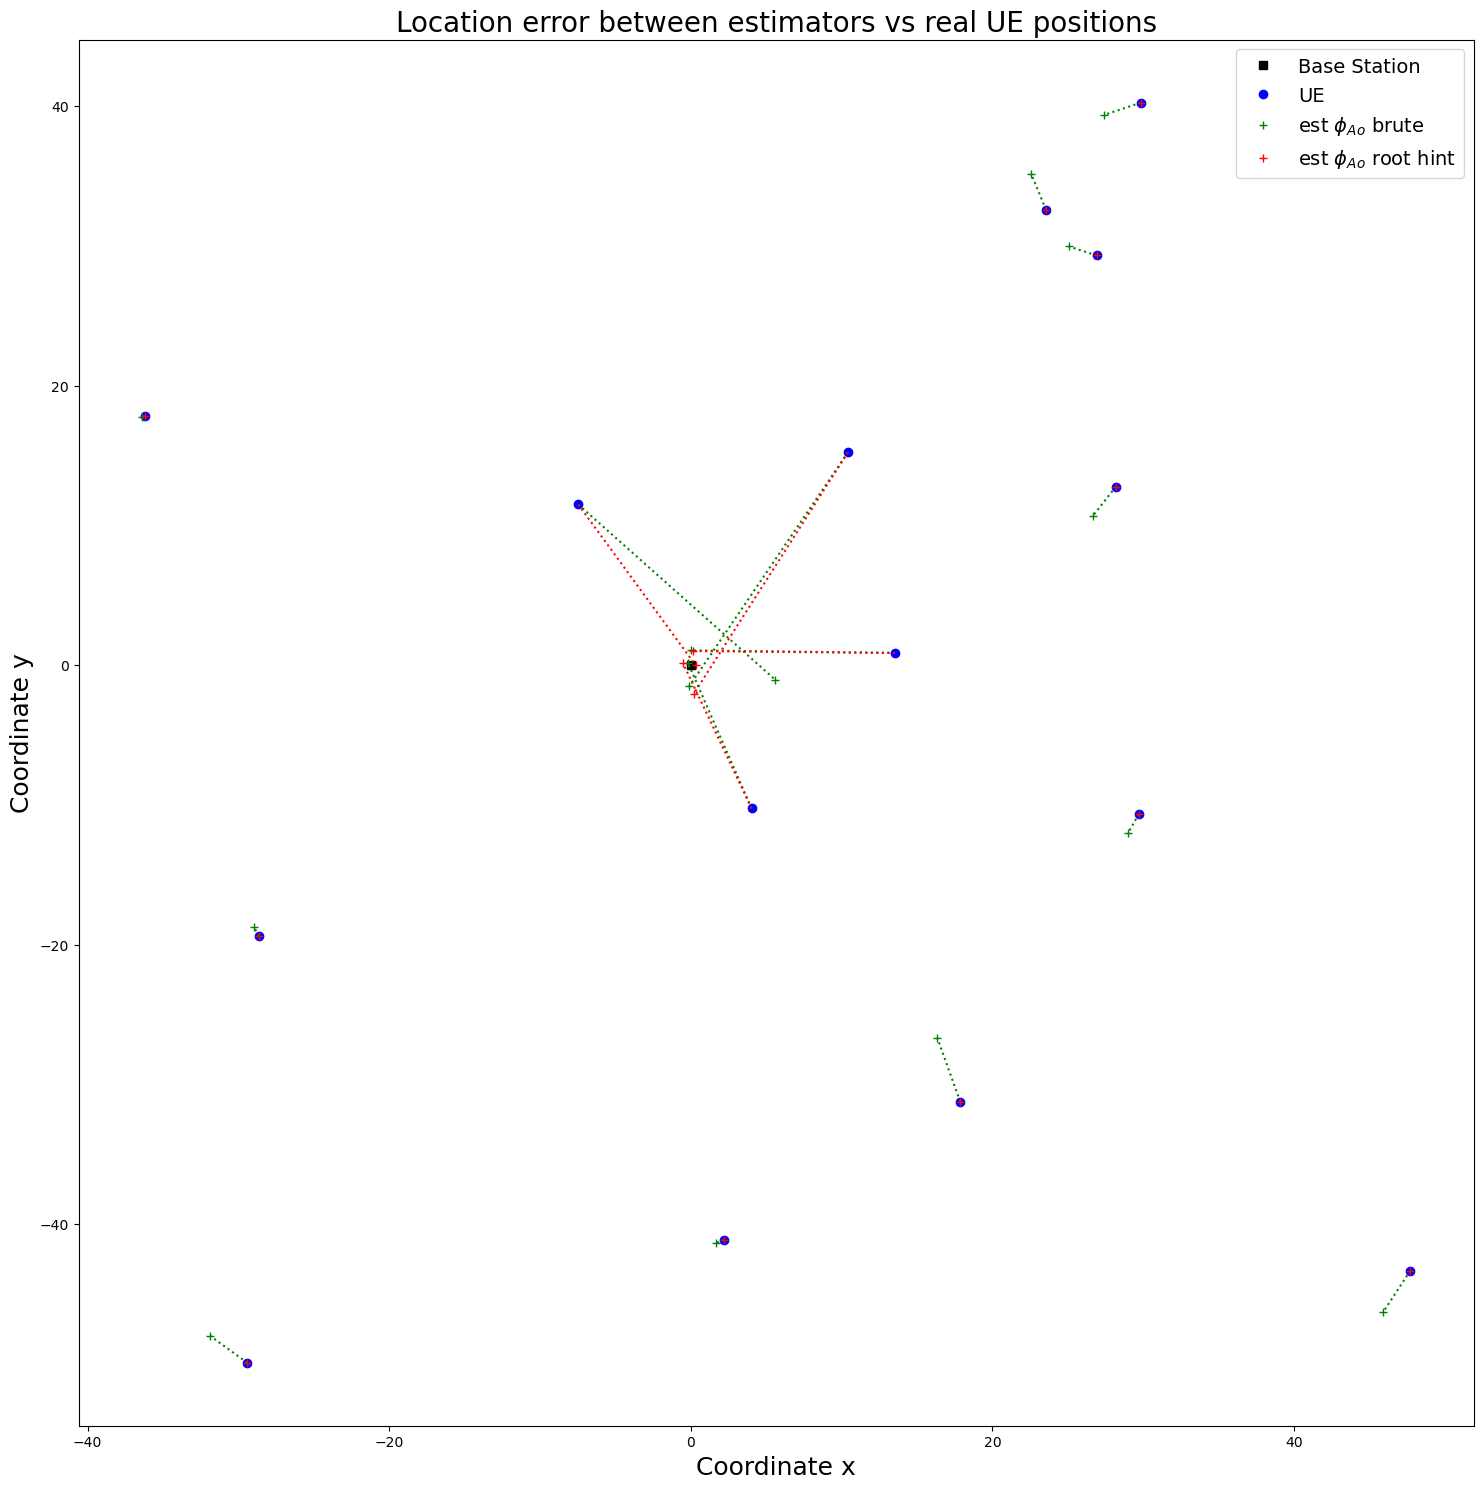

In [12]:
# Number of scattering paths (number of scatters)
Npath = 20

# Number of total users allocated in the plane
Nuser = 15

# We generate random locations for scatters in a 100m [-50 y 50] square
# We place one scatter in each NLOS path
d_ix = np.random.rand(Nuser, Npath)*100 - 50
d_iy = np.random.rand(Nuser, Npath)*100 - 50

# We generate a random location for Nuser users
d_0x = np.random.rand(Nuser)*100 - 50
d_0y = np.random.rand(Nuser)*100 - 50

# All angles are in radians units
# With el mod operator, we substract 2pi from the angle if it is higher than 2pi
AoD_0 = np.arctan(d_0y/d_0x)
AoD_0 = np.mod(AoD_0 + np.pi*(d_0x < 0), 2*np.pi)

AoD_i = np.arctan(d_iy/d_ix)
AoD_i = np.mod(AoD_i + np.pi*(d_ix < 0), 2*np.pi)

AoA_i = np.arctan((d_iy - d_0y[:,None])/(d_0x[:,None] - d_ix))
AoA_i = np.mod(np.pi - AoA_i + np.pi*((d_0x[:,None] - d_ix) < 0), 2*np.pi)

# Ligth speed
c = 3e8

# LOS path length
l_0 = abs(d_0y / np.sin(AoD_0))

# LOS path time delay
ToA_0 = l_0 / c

# NLOS path length
l_i = np.abs(d_iy / np.sin(AoD_i)) + np.abs((d_iy - d_0y[:,None]) / np.sin(AoA_i))

# NLOS path time delay
ToA_i = l_i / c

# We generate a random angle for the offset
AoA_0 = np.random.rand(Nuser)*2*np.pi

AoD_i = np.mod(AoD_i, 2*np.pi)

DAoA_i = np.mod(AoA_i - AoA_0[:,None], 2*np.pi)

TDoA_i = ToA_i - ToA_0 [:,None]

allPathsData = pd.DataFrame(index=pd.MultiIndex.from_product([np.arange(Nuser),np.arange(Npath)]),
                            data={
                                "AoD" : AoD_i.reshape(-1),
                                "DAoA" : DAoA_i.reshape(-1),
                                "TDoA" : TDoA_i.reshape(-1)
                                })
print(allPathsData)

plt.figure(5)

# Plot the Base Station
plt.plot(0, 0, "sk", label="Base Station")

# Plot the User
plt.plot(d_0x, d_0y,"ob",label="UE")

for ue in tqdm(range(Nuser)):
    (d_0_brute, _ ,_ , AoA0_brute,_) = loc.computeAllLocationsFromPaths(allPathsData.loc[ue,:] ,orientationMethod='brute', orientationMethodArgs={'groupMethod':'drop1','nPoint':100})   
    plt.plot(d_0_brute[0], d_0_brute[1],"+g",label="est $\\phi_{Ao}$ brute")
    plt.plot([d_0x[ue], d_0_brute[0]], [d_0y[ue], d_0_brute[1]], ":g")

    (d_0_root, _ ,_ , AoA0_root,_) = loc.computeAllLocationsFromPaths(allPathsData.loc[ue,:] ,orientationMethod='lm', orientationMethodArgs={'groupMethod':'drop1','initRotation':AoA0_brute})
    plt.plot(d_0_root[0], d_0_root[1],"+r",label="est $\\phi_{Ao}$ root hint")
    plt.plot([d_0x[ue], d_0_root[0]], [d_0y[ue], d_0_root[1]], ":r")

plt.title("Location error between estimators vs real UE positions",  fontsize=20)
plt.xlabel("Coordinate x",  fontsize=18)
plt.ylabel("Coordinate y",  fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

## 5.1 Solving UE location with channel estimation errors

Next, we use the methods explained in previous sections but introducing now some errors in channel parameters measurements to simulate possibles errors introduced in the position estimation. For this, you can go back to [Section 3](#3.-Solving-UE-location-with-clock-error) to refresh clock offset error basics. For this part, we use the same UE, BS and scatter map. Additionally, clock error is randomly distributed as $\tau_e\sim U(0, 40ns)$. Moreover, we introduce a quantization error in the AoDs and AoAs in order to simulate an ideal result of dictionary-based Compressed Sensing channel estimation.

So, instead of known $\{\phi_{Di}, \Delta\phi_{Ai}, \Delta\tau_i\}$ we feed the estimation algorithm the set of values $\{\mathscr{Q}_{\pi/N_a}(\phi_{Di}), \mathscr{Q}_{\pi/N_a}(\Delta\phi_{Ai}), \Delta\tau_i + \tau_E\}$, where the quantization error is modeled as
\begin{equation}
\mathscr{Q}_{\pi/N_a}(x)=\mathrm{round}(xN_a/\pi)*pi/N_a
\end{equation}
with Na = 256, a tuning parameter intended to represent the number of atoms of the angle estimation dictionary. Moreover, the delay estimation error is modeled as:
\begin{equation}
\tau_{E} \sim N(0, T_s^2) 
\end{equation}
where 
\begin{equation}
T_s = \frac{1}{B} = 2.5 ns = \frac{1}{400 MHz}
\end{equation} 
intended to represent the Nyquist sampling period of a 5G mmWave signal with 400MHz bandwidth.

            AoD      DAoA          TDoA
0  0   5.252350  2.650719  3.746125e-07
   1   1.963495  5.546875  2.329896e-07
   2   3.607923  1.300816  2.519858e-07
   3   0.613592  3.853360  1.710094e-07
   4   3.092505  1.300816  6.792137e-08
...         ...       ...           ...
14 15  3.804272  0.981748  4.205028e-07
   16  1.840777  6.185011  1.559176e-07
   17  0.859029  4.417865  7.090808e-08
   18  1.325359  0.883573  7.342053e-09
   19  0.368155  1.178097  3.583358e-09

[300 rows x 3 columns]


  0%|          | 0/15 [00:00<?, ?it/s]

/home/fgomez/Workspace/py5g/Tutorials/../CASTRO5G/MultipathLocationEstimator.py:277: RuntimeWarning: divide by zero encountered in divide
  Vi=(DoD+C12[:,None]*DoA)/(1-C12[:,None]**2)
/home/fgomez/Workspace/py5g/Tutorials/../CASTRO5G/MultipathLocationEstimator.py:268: RuntimeWarning: invalid value encountered in divide
  M=np.column_stack([(DoD-DoA)/(1+C12[:,None]),-np.ones((Npath,1))])
/home/fgomez/Workspace/py5g/Tutorials/../CASTRO5G/MultipathLocationEstimator.py:277: RuntimeWarning: invalid value encountered in divide
  Vi=(DoD+C12[:,None]*DoA)/(1-C12[:,None]**2)
/home/fgomez/Workspace/py5g/Tutorials/../CASTRO5G/MultipathLocationEstimator.py:268: RuntimeWarning: divide by zero encountered in divide
  M=np.column_stack([(DoD-DoA)/(1+C12[:,None]),-np.ones((Npath,1))])


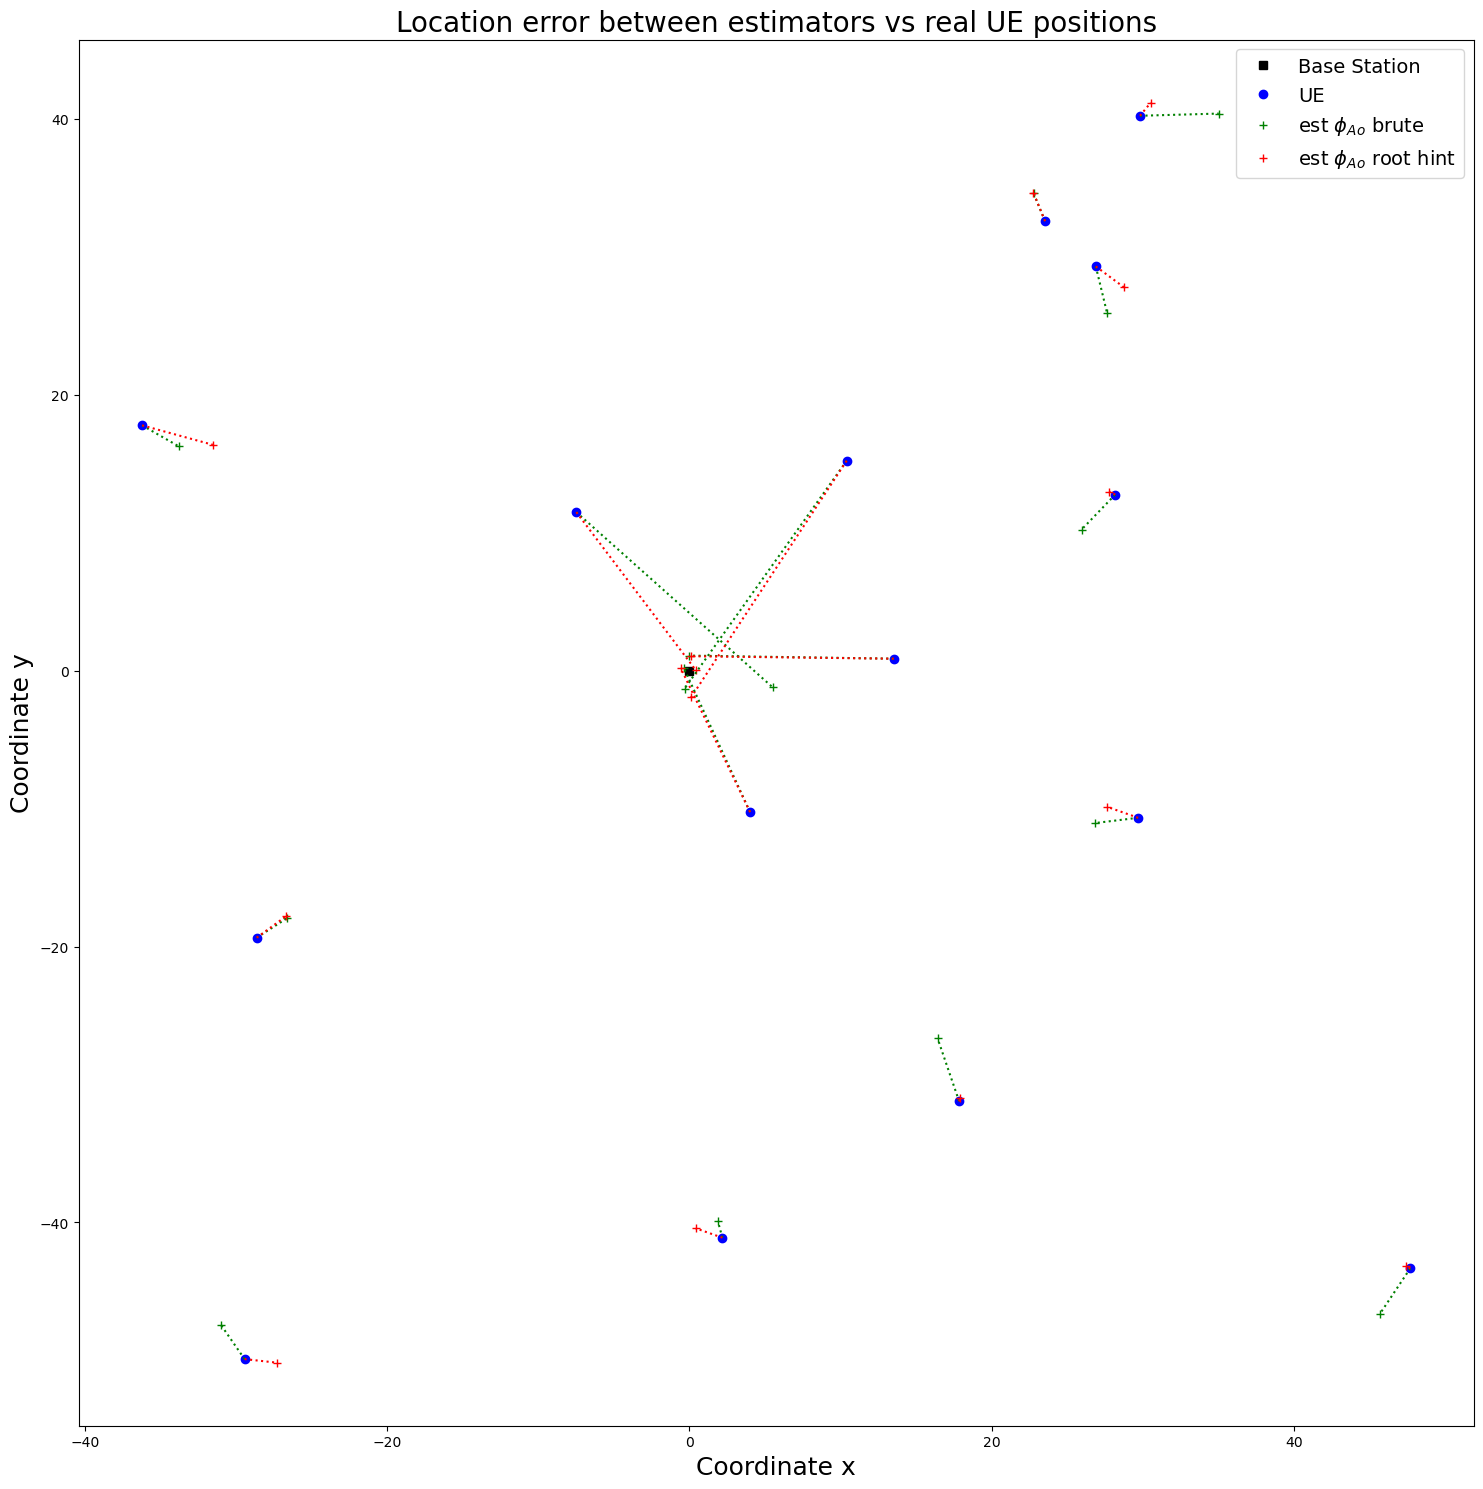

In [14]:
#delay estimation error
clock_error=(2.5e-9)*np.random.randn(Nuser)
Na = 128
TDoA_est = TDoA_i + clock_error[:,None]
AoD_est = np.round(AoD_i*Na/np.pi)*np.pi/Na
DAoA_est = np.round(DAoA_i*Na/np.pi)*np.pi/Na

allPathsData_est = pd.DataFrame(index=pd.MultiIndex.from_product([np.arange(Nuser),np.arange(Npath)]),
                            data={
                                "AoD" : AoD_est.reshape(-1),
                                "DAoA" : DAoA_est.reshape(-1),
                                "TDoA" : TDoA_est.reshape(-1)
                                })
print(allPathsData_est)

plt.figure(5)

# Plot the Base Station
plt.plot(0, 0, "sk", label="Base Station")

# Plot the User
plt.plot(d_0x, d_0y,"ob",label="UE")

for ue in tqdm(range(Nuser)):
    (d_0_brute, _ ,_ , AoA0_brute,_) = loc.computeAllLocationsFromPaths(allPathsData_est.loc[ue,:] ,orientationMethod='brute', orientationMethodArgs={'groupMethod':'drop1','nPoint':100})   
    plt.plot(d_0_brute[0], d_0_brute[1],"+g",label="est $\\phi_{Ao}$ brute")
    plt.plot([d_0x[ue], d_0_brute[0]], [d_0y[ue], d_0_brute[1]], ":g")

    (d_0_root, _ ,_ , AoA0_root,_) = loc.computeAllLocationsFromPaths(allPathsData_est.loc[ue,:] ,orientationMethod='lm', orientationMethodArgs={'groupMethod':'drop1','initRotation':AoA0_brute})
    plt.plot(d_0_root[0], d_0_root[1],"+r",label="est $\\phi_{Ao}$ root hint")
    plt.plot([d_0x[ue], d_0_root[0]], [d_0y[ue], d_0_root[1]], ":r")

plt.title("Location error between estimators vs real UE positions",  fontsize=20)
plt.xlabel("Coordinate x",  fontsize=18)
plt.ylabel("Coordinate y",  fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

# 6. Performance of the methods 

We now condunct the simulation for Nuser=50 using all the methods described above and compare their behavior.

First, we plot the C.D.F. of the location error in m. We see that the 'root' method achieves much better precision than the 'brute' method. Nevertheless, the result is rather hit-or-miss, as some of the user locations are estimated with poor accuracy. This is correlated with the events when the orientation is not estimated accurately because the root method converges to an incorrect stationary point.


Solving UEs with brute algorithm params {'groupMethod': 'drop1', 'nPoint': 100}:   0%|          | 0/15 [00:00<…

Solving UEs with lm algorithm params {'groupMethod': '3path'}:   0%|          | 0/15 [00:00<?, ?it/s]

Solving UEs with lm algorithm params {'groupMethod': 'drop1'}:   0%|          | 0/15 [00:00<?, ?it/s]

Solving UEs with lm algorithm params {'groupMethod': 'random'}:   0%|          | 0/15 [00:00<?, ?it/s]

Solving UEs with lm algorithm params {'groupMethod': '3path', 'initRotation': 'TBD'}:   0%|          | 0/15 [0…

Solving UEs with lm algorithm params {'groupMethod': 'drop1', 'initRotation': 'TBD'}:   0%|          | 0/15 [0…

Solving UEs with lm algorithm params {'groupMethod': 'random', 'initRotation': 'TBD'}:   0%|          | 0/15 […

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

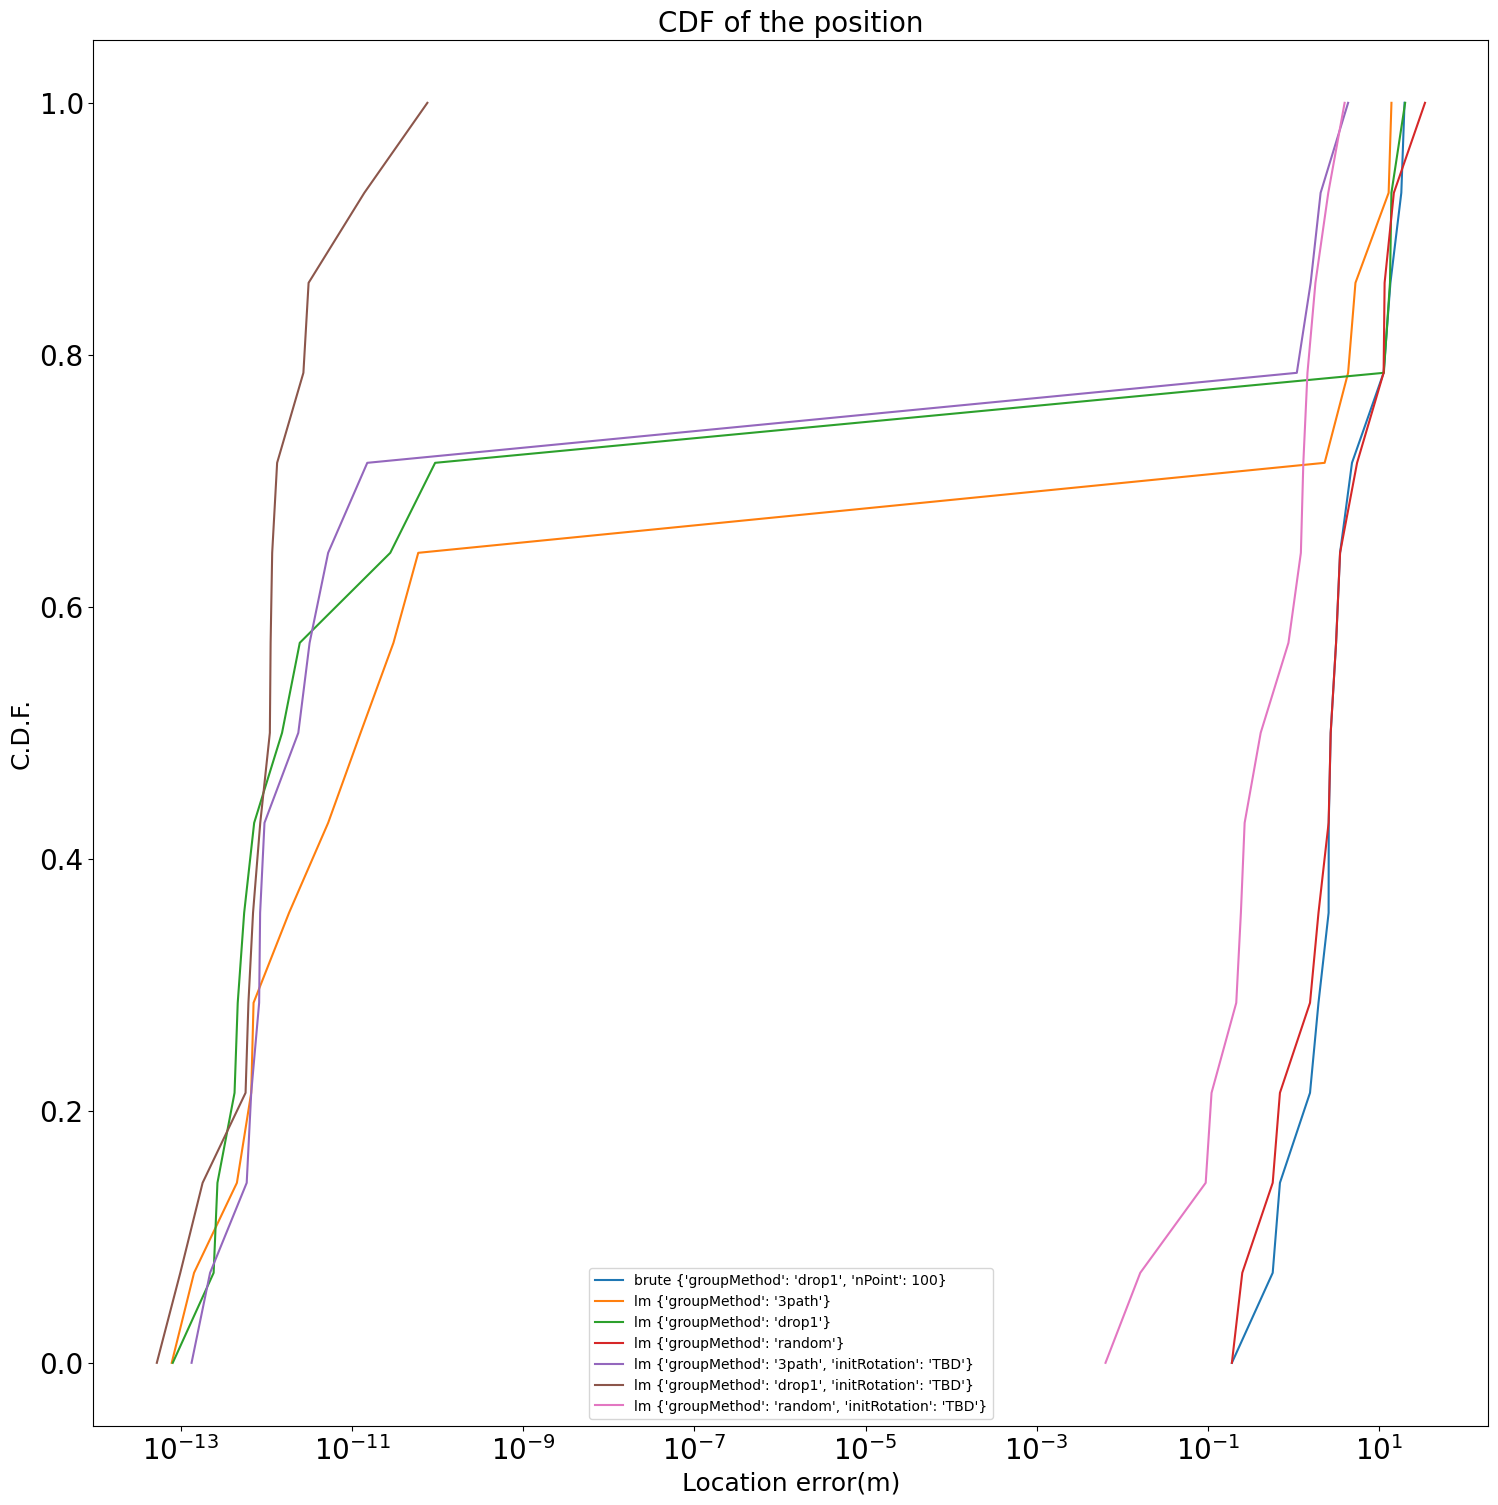

In [15]:
algTable = [
    ('brute',{'groupMethod':'drop1','nPoint':100}),
    ('lm',{'groupMethod':'3path'}),
    ('lm',{'groupMethod':'drop1'}),
    ('lm',{'groupMethod':'random'}),
    ('lm',{'groupMethod':'3path','initRotation':"TBD"}),
    ('lm',{'groupMethod':'drop1','initRotation':"TBD"}),
    ('lm',{'groupMethod':'random','initRotation':"TBD"}),
]
Nalgs = len(algTable)
algStrLabels=[f'{a[0]} {a[1]}' for a in algTable]

AoA0_est = np.zeros((Nalgs,Nuser))
tauerr_est = np.zeros((Nalgs,Nuser))
d0_est = np.zeros((Nalgs,Nuser,2))
d_est = np.zeros((Nalgs,Nuser,Npath,2))
run_times = np.zeros((Nalgs,Nuser))

for a in range(Nalgs):
    algname,algparam=algTable[a]
    for ue in tqdm(range(Nuser),desc=f'Solving UEs with {algname} algorithm params {algparam}'):
        t_start = time.time()
        if 'initRotation' in algparam.keys():
            algparam['initRotation']= np.round(AoA_0[ue]*128/np.pi)*np.pi/128
        (d0_est[a,ue,:], tauerr_est[a,ue], d_est[a,ue,:,:], AoA0_est[a,ue],_) = loc.computeAllLocationsFromPaths(allPathsData.loc[ue,:] ,orientationMethod=algname, orientationMethodArgs=algparam)
        run_times[a,ue]= time.time() - t_start

error_loc = np.linalg.norm(d0_est-np.vstack([d_0x, d_0y]).T,axis=2)

plt.semilogx(np.sort(error_loc,axis=1).T, np.linspace(0, 1, Nuser))

plt.title("CDF of the position",  fontsize=20)
plt.legend(algStrLabels)
plt.xlabel('Location error(m)', fontsize=18)
plt.ylabel('C.D.F.', fontsize=18)
plt.xticks(fontsize = 20) 
plt.yticks(fontsize = 20) 

Next we depict the run time of all the algorithms. We observe that the 'root' method with a good initialization point is much faster; this is caused mostly by the fact that the 'brute' method is fell back to as initialization when a hint is not provided.

Text(0, 0.5, '$\\phi_{Ao}$ method')

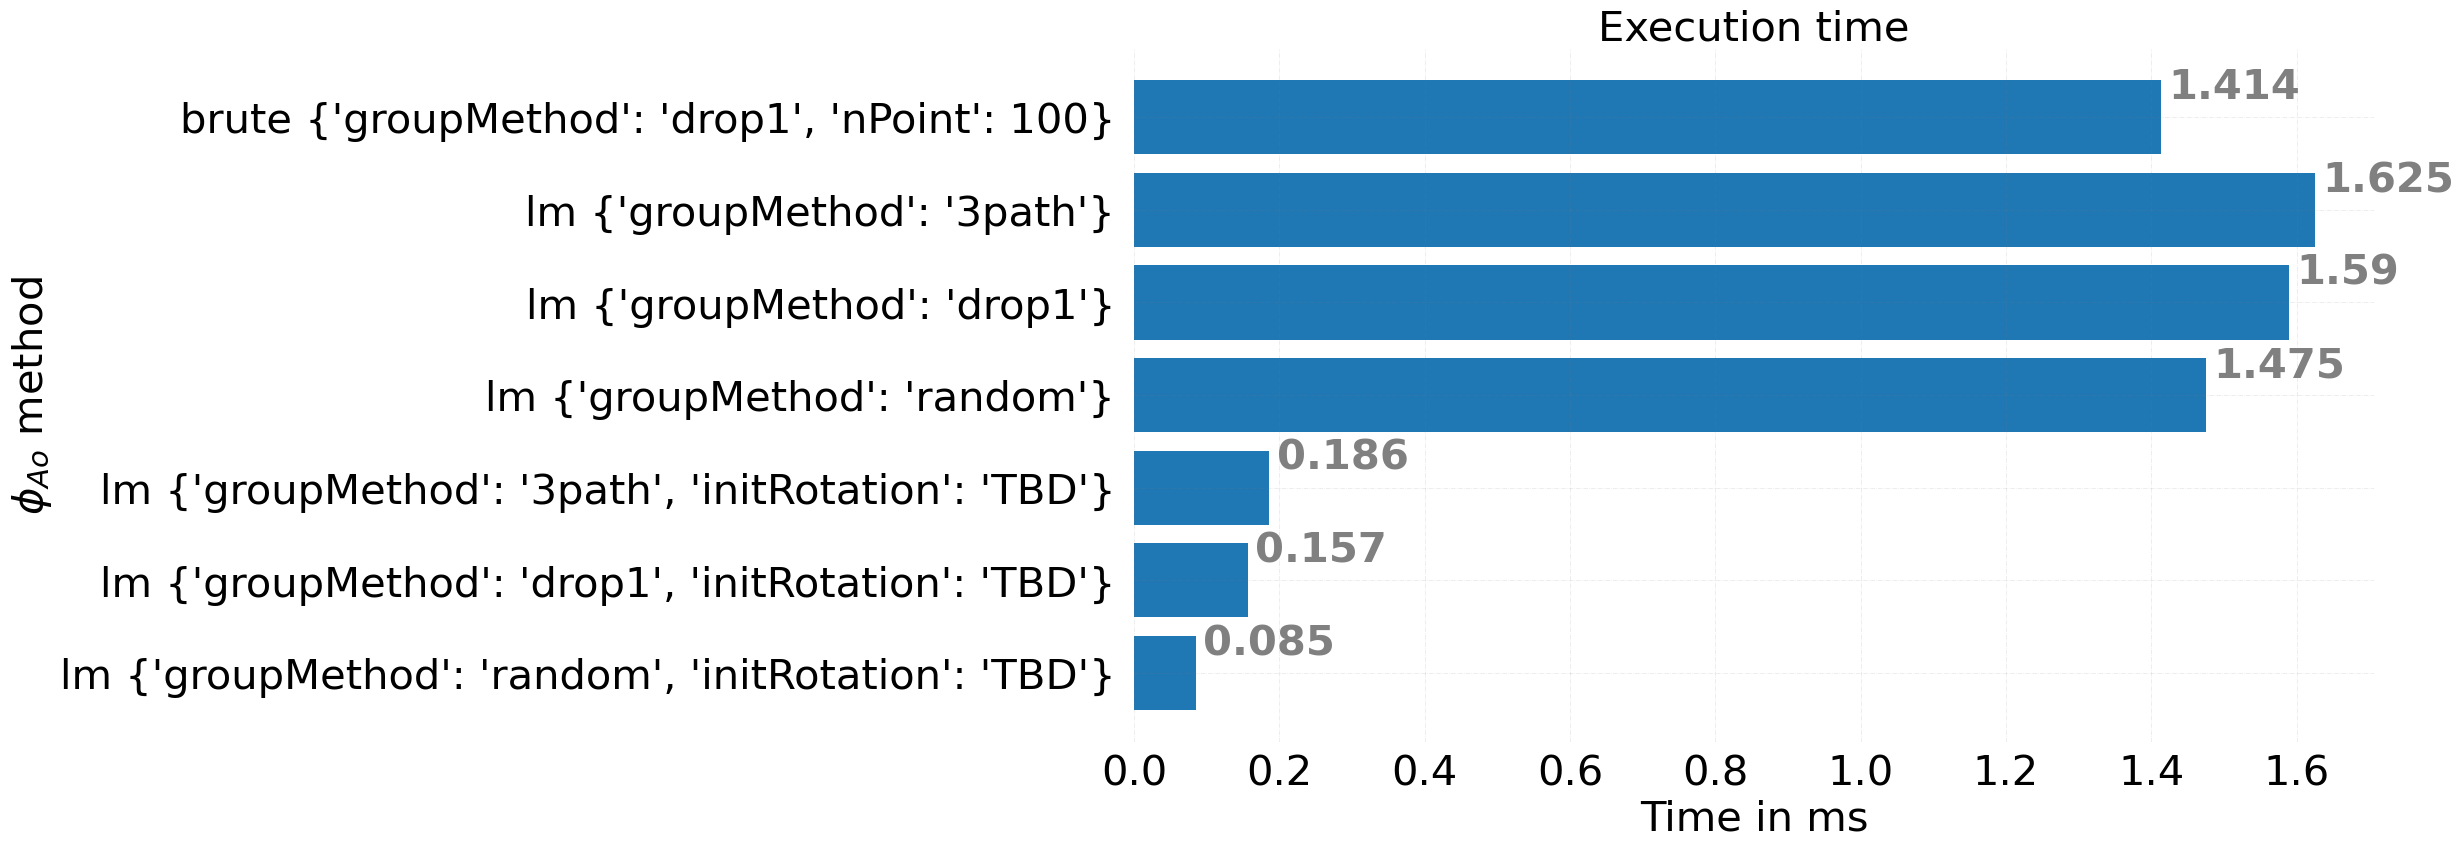

In [17]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(algStrLabels, np.mean(run_times,axis=1))

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(visible = True, color ='grey',
		linestyle ='-.', linewidth = 0.5,
		alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.01, i.get_y()+0.2,
			str(round((i.get_width()), 3)),
			fontsize = 30, fontweight ='bold',
			color ='grey')

plt.xticks(fontsize = 30) 
plt.yticks(fontsize = 30) 

plt.title("Execution time",  fontsize=30)
plt.xlabel("Time in ms",  fontsize=30)
plt.ylabel("$\\phi_{Ao}$ method",  fontsize=30)

Next we depict the C.D.F. of the estimation of $\phi_o$. This highlights the similitude between the location estimation performance and the orientation estimation performance.

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

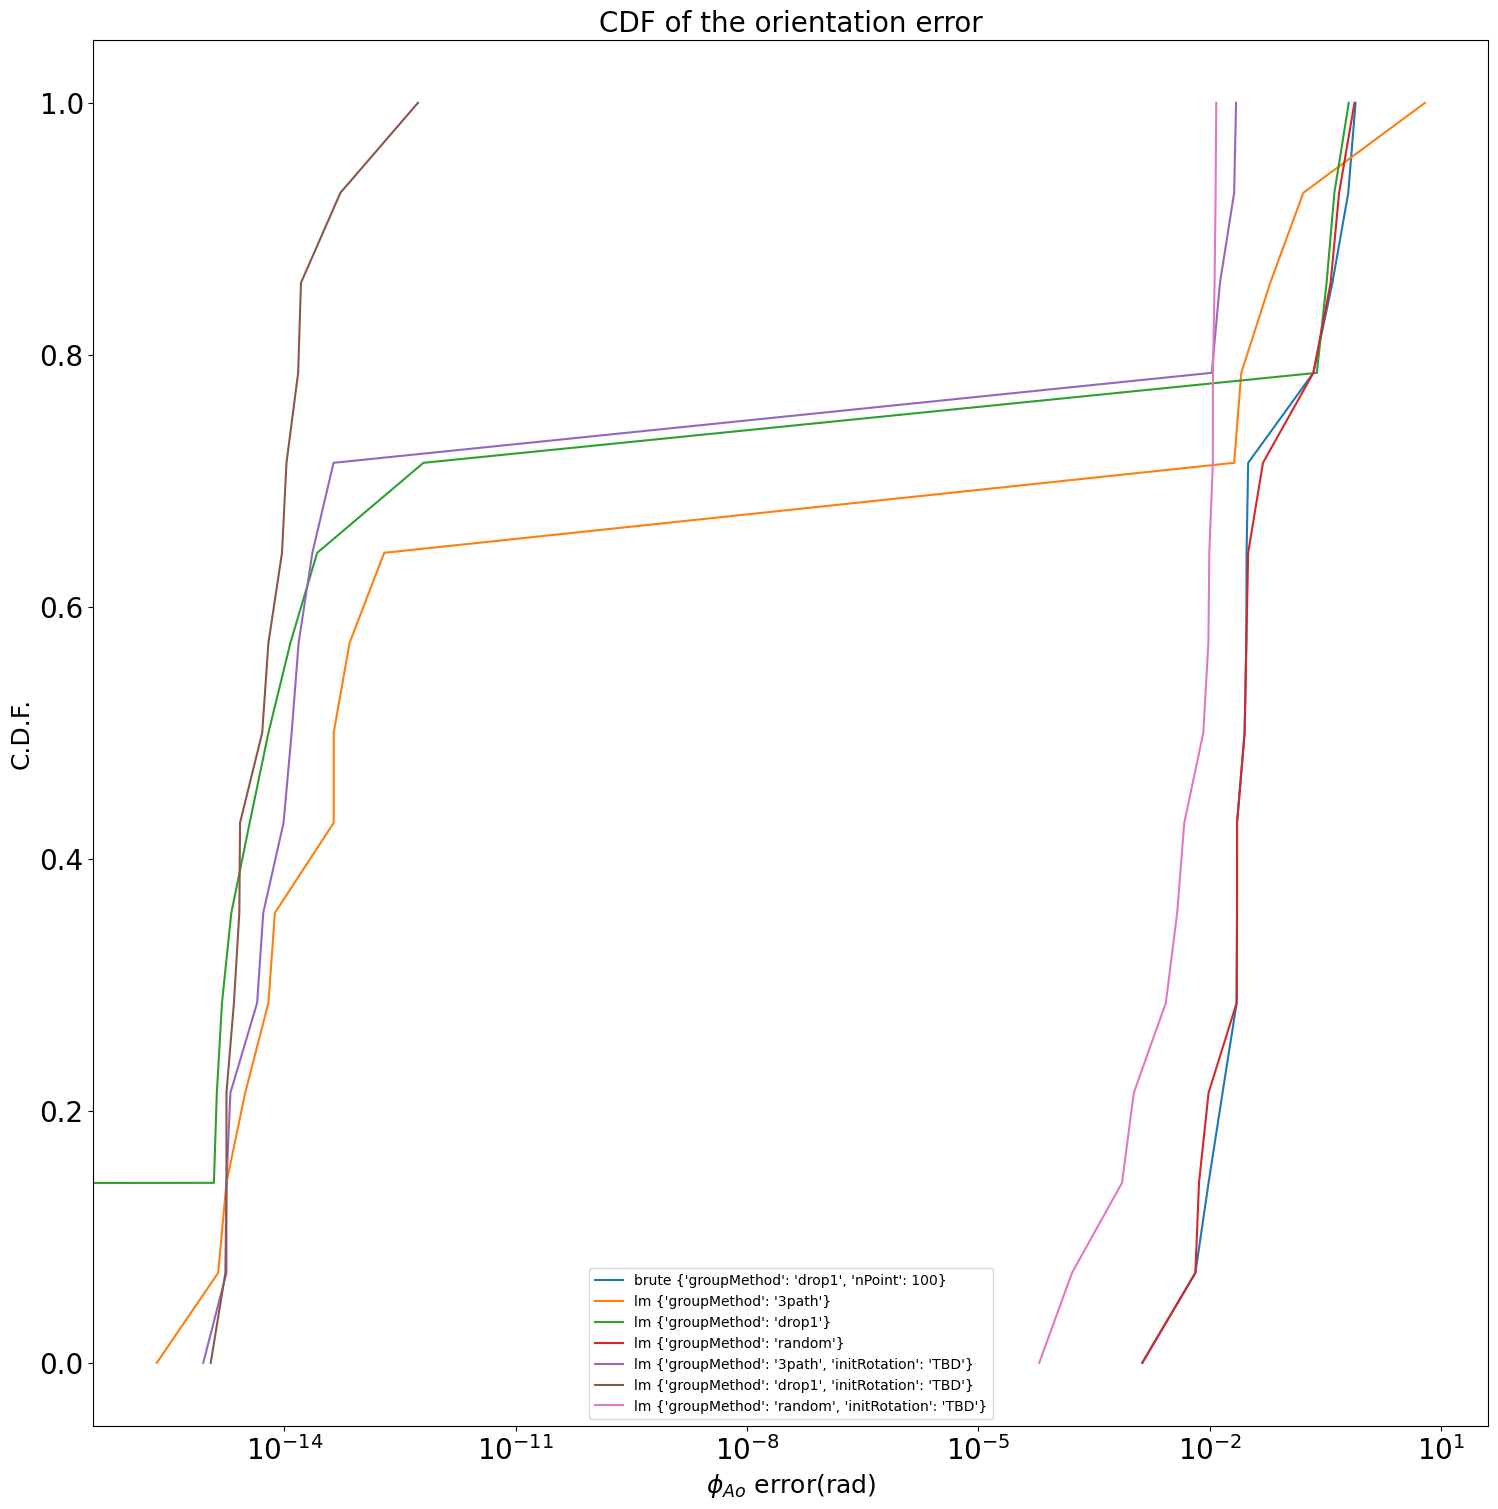

In [19]:
plt.figure(7)

error_aoa0 = np.sqrt(np.abs(AoA0_est - AoA_0)**2)

plt.semilogx(np.sort(error_aoa0,axis=1).T, np.linspace(0,1,Nuser))

plt.title("CDF of the orientation error",  fontsize=20)
plt.legend(algStrLabels)
plt.xlabel('$\\phi_{Ao}$ error(rad)', fontsize=18)
plt.ylabel('C.D.F.', fontsize=18)
plt.xticks(fontsize = 20) 
plt.yticks(fontsize = 20) 

The clock error estimation is in the range of a few ns for all algorithms.

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

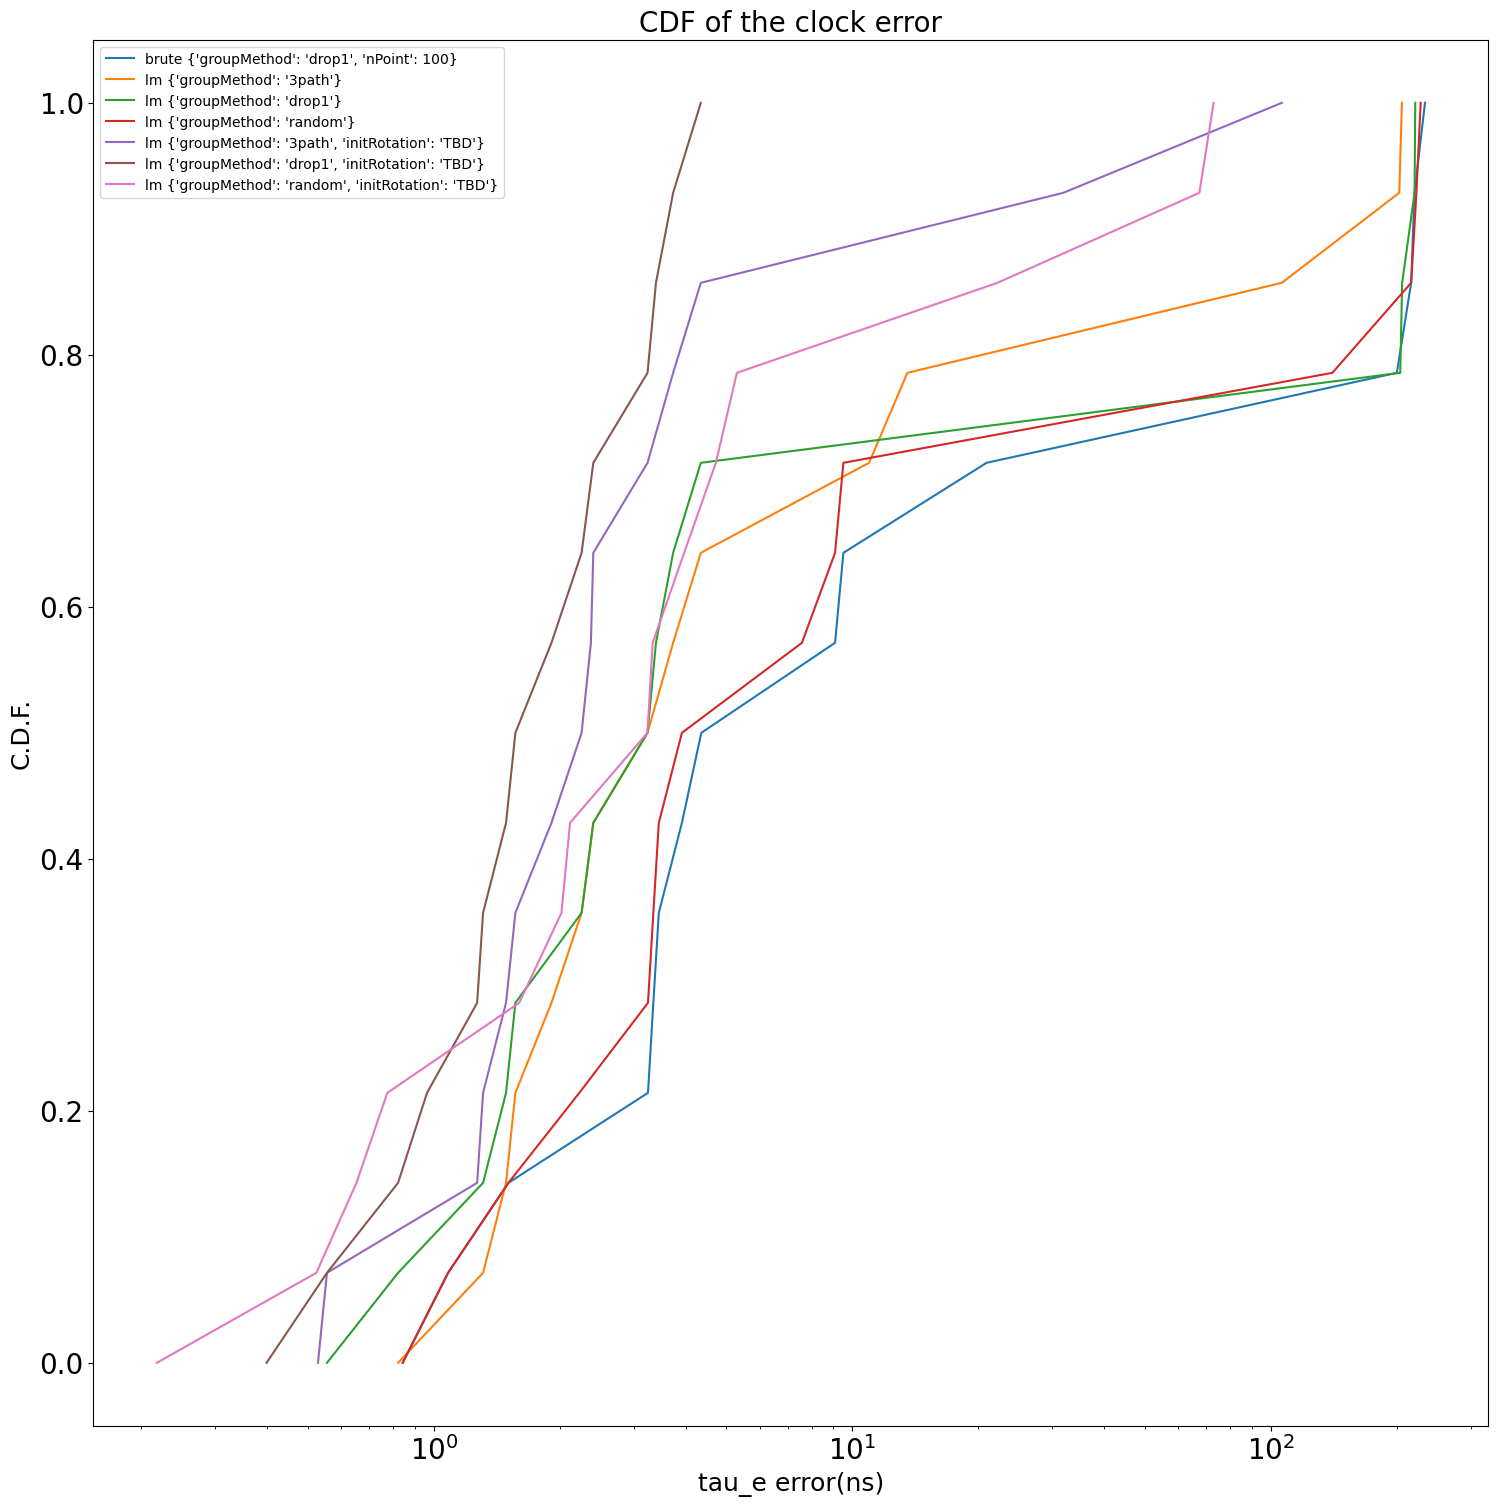

In [20]:
plt.figure(8)

error_tau = np.sqrt(np.abs(tauerr_est - clock_error)**2)

plt.semilogx(np.sort(1e9*error_tau,axis=1).T, np.linspace(0,1,Nuser))

plt.title("CDF of the clock error",  fontsize=20)
plt.legend(algStrLabels)
plt.xlabel('tau_e error(ns)', fontsize=18)
plt.ylabel('C.D.F.', fontsize=18)
plt.xticks(fontsize = 20) 
plt.yticks(fontsize = 20) 

# 6.1 Group Size

Next we are going to explore the influence of the group size, by performing estimations with 0, 1, 2 .... N users per group.

In [25]:
list_table_group = []
for k in range(10):
    list_table_group.append( loc.genKPathGroup(20,k+1) )
for k in range(9):
    list_table_group.append( np.invert(list_table_group[10-k-2]) )

In [26]:
AoA0_est_npath = np.zeros((19,Nuser))
tauerr_npath = np.zeros((19,Nuser))

d_0_est = np.zeros((Nuser,2))

plt.figure(8)

error_fsolve_npath = np.zeros((19,Nuser))
t_run_fsolve_npath = np.zeros(19)
for n in range(19):
    t_start = time.time()
    for ue in tqdm(range(Nuser),desc=f'fsolve_{n}path'):
        (d0_est[a,ue,:], tauerr_est[a,ue], d_est[a,ue,:,:], AoA0_est[a,ue],_) = loc.computeAllLocationsFromPaths(allPathsData.loc[ue,:] ,orientationMethod='lm', orientationMethodArgs={'groupMethod':list_table_group[n]}) 
    error_fsolve_npath[n,:] = np.sqrt(np.abs(d_0x - d_0_est[:,0])**2 + np.abs(d_0y - d_0_est[:,1]))
    t_run_fsolve_npath[n] = time.time() - t_start

fsolve_0path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_1path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_2path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_3path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_4path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_5path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_6path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_7path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_8path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_9path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_10path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_11path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_12path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_13path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_14path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_15path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_16path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_17path:   0%|          | 0/15 [00:00<?, ?it/s]

fsolve_18path:   0%|          | 0/15 [00:00<?, ?it/s]

<Figure size 1800x1800 with 0 Axes>

Text(0, 0.5, 'Number of gruped paths')

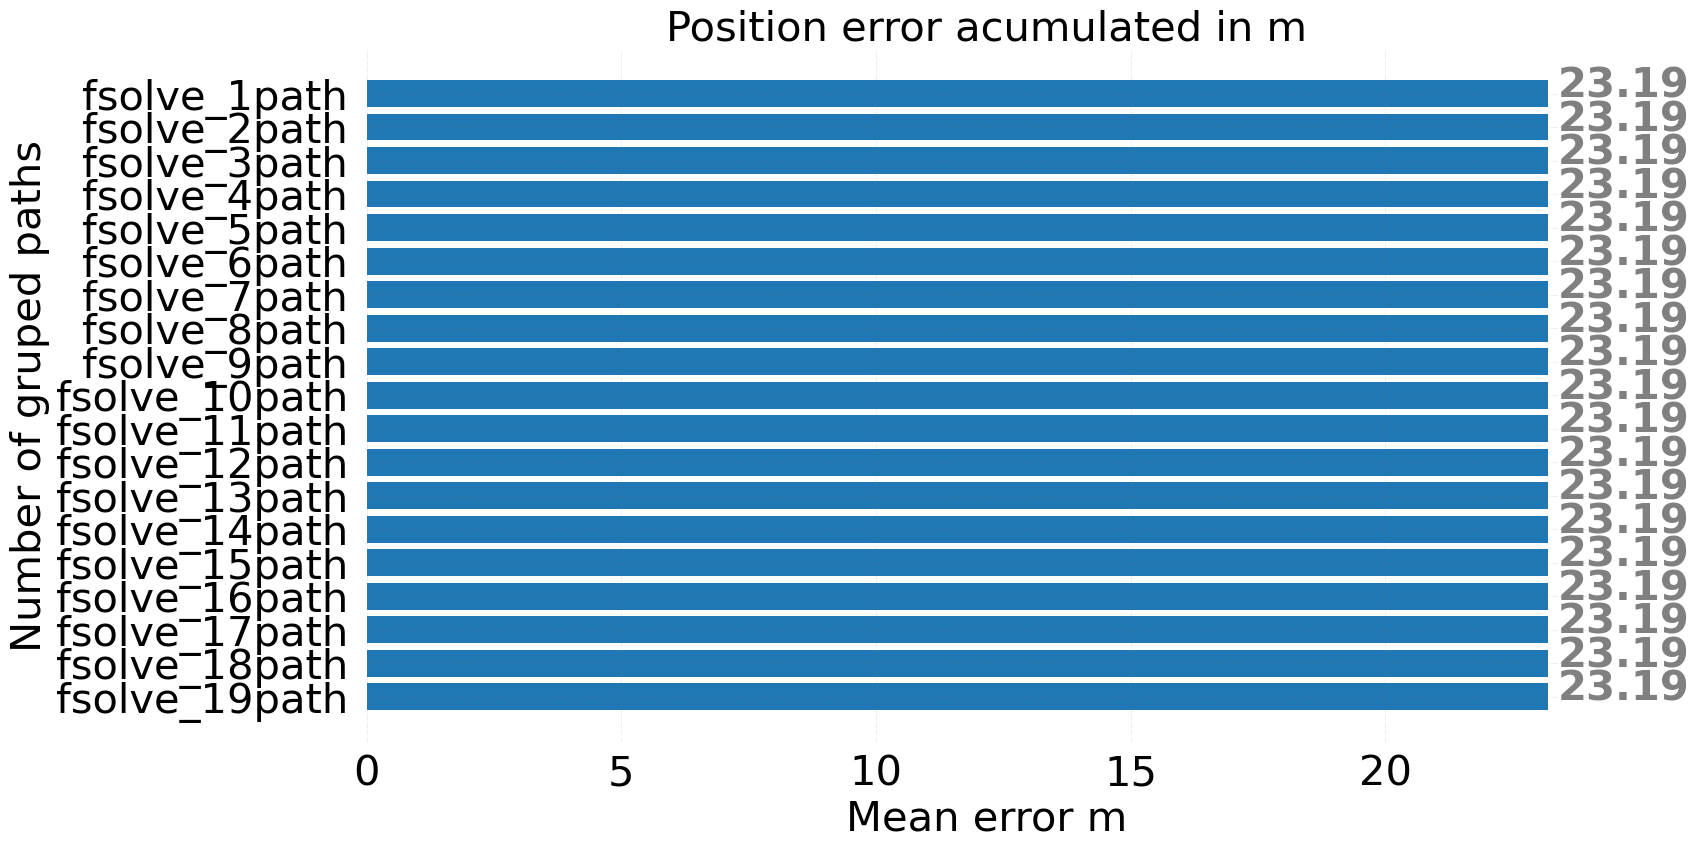

In [27]:
labels = ['fsolve_%dpath'%(x+1) for x in range(19)]
error = np.mean(error_fsolve_npath,axis=1)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(labels, error)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(visible = True, color ='grey',
		linestyle ='-.', linewidth = 0.5,
		alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.2, i.get_y()+0.5,
			str(round((i.get_width()), 2)),
			fontsize = 30, fontweight ='bold',
			color ='grey')

plt.xticks(fontsize = 30) 
plt.yticks(fontsize = 30) 

plt.title("Position error acumulated in m",  fontsize=30)
plt.xlabel("Mean error m",  fontsize=30)
plt.ylabel("Number of gruped paths",  fontsize=30)

Text(0, 0.5, 'Number of gruped paths')

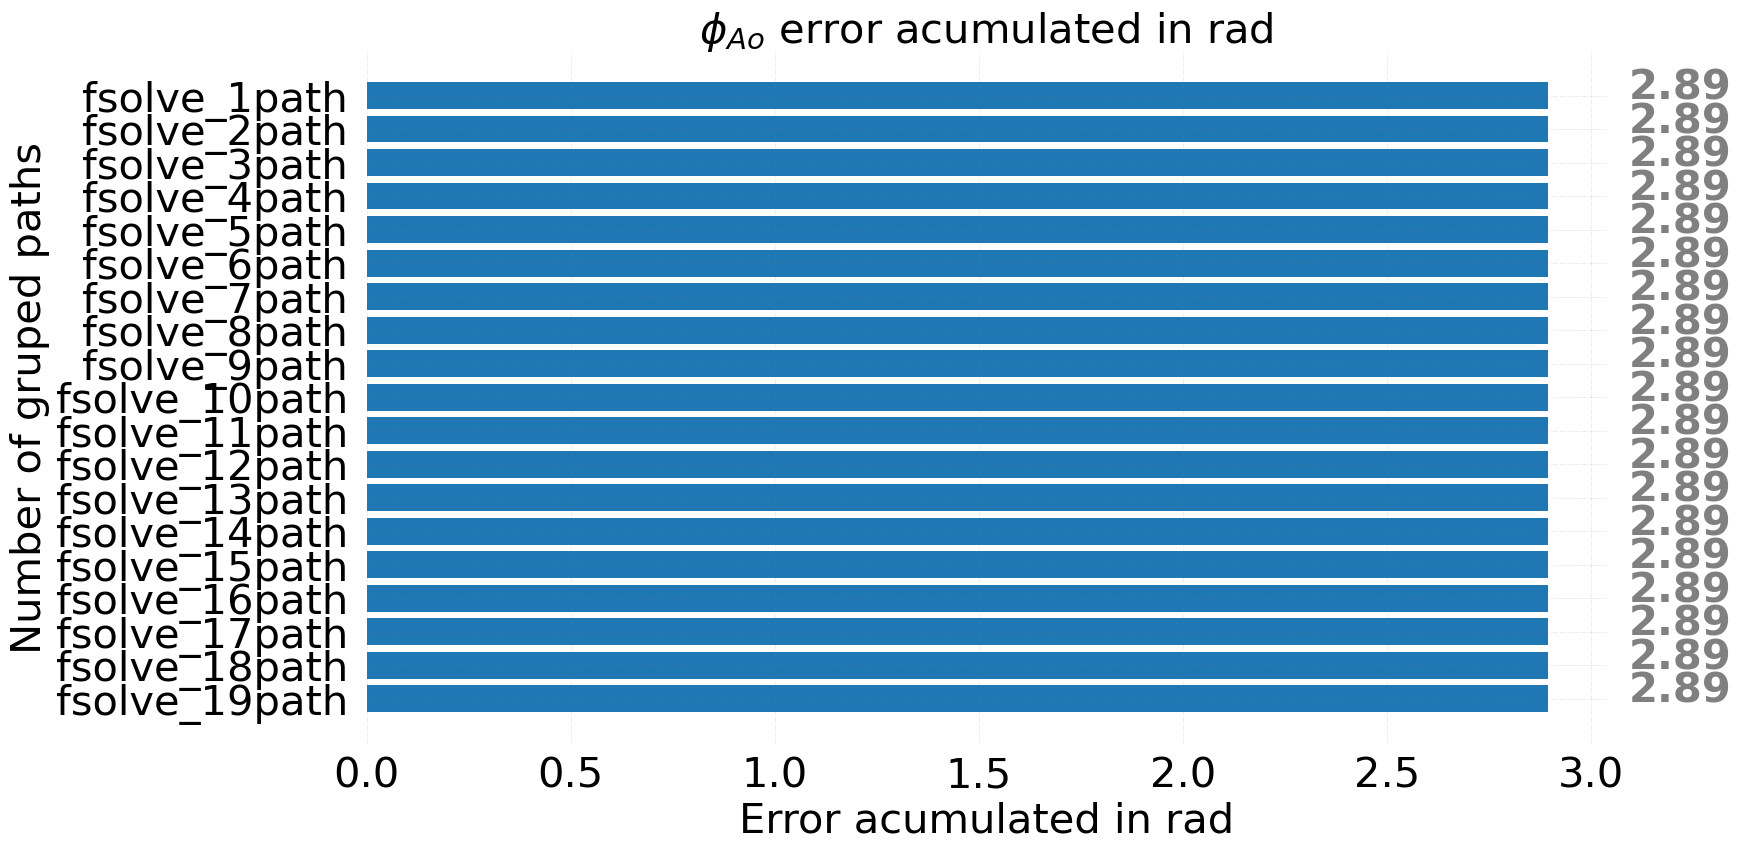

In [29]:
AoA0E_fsolve_npath = np.mean(np.sqrt(np.abs(AoA0_est_npath - AoA_0)**2),axis=1)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(labels, AoA0E_fsolve_npath)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(visible = True, color ='grey',
		linestyle ='-.', linewidth = 0.5,
		alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.2, i.get_y()+0.5,
			str(round((i.get_width()), 2)),
			fontsize = 30, fontweight ='bold',
			color ='grey')

plt.xticks(fontsize = 30) 
plt.yticks(fontsize = 30) 

plt.title("$\\phi_{Ao}$ error acumulated in rad",  fontsize=30)
plt.xlabel("Error acumulated in rad",  fontsize=30)
plt.ylabel("Number of gruped paths",  fontsize=30)

<a class="anchor" id="7"></a>

<br><br>
<span style="color:black; font-size:33px; font-family: Cambria"><b> 7. References </b></span>
<br>


[1] Felipe Gomez-Cuba. Multipath absolute clock recovery and location. page 12.

[2] Felipe Gómez-Cuba, Nuria González-Prelcic, and Gonzalo Feijoo Rodríguez. Clock and orientation-robust location and mapping from multipath channel estimation. page 6.